# Biomass Reference Map Production

This is a prototype notebook for creating biomass reference maps in R using airborne lidar and field inventory data.

### Extending field inventories with airborne lidar
The purpose of this notebook is to use local relationships between forest inventory data and airborne lidar to create biomass reference maps that cover a larger area than is practical to collect in the field. Forest metrics such as canopy height and canopy cover can be extracted from discrete return lidar and related to aboveground biomass measurements from the field. This relationship produces a locally-calibrated model for predicting aboveground biomass from airborne lidar, and this model is applied to lidar data outside of the field plot to garner predictions of gridded aboveground biomass density.

The process will be following Armston et al. 2020. AfriSAR: Gridded Forest Biomass and Canopy Metrics Derived from LVIS, Gabon, 2016. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1775


***

### The first steps in this notebook are about preparing your workspace and loading the airborne lidar data



### **1.** This notebook is designed to run on the NASA MAAP in a "MAAP R Stable" workspace. 
To prepare your workspace, install packages via the terminal and restart the kernel in this notebook by either:

&emsp;**a.** Install from configuration file (this is much faster):

&emsp;&emsp;`conda env update -f /projects/shared-buckets/minord/biomass_reference_maps/env/biomass-reference-env.yml --prune`

&emsp;&emsp;`conda env create -f /projects/shared-buckets/minord/biomass_reference_maps/env/greta-env.yml`

&emsp;**b.** Install from scratch (may take 2+ hours)

&emsp;&emsp;`conda install -c conda-forge r-lidr r-future r-viridis r-greta r-igraph r-bayesplot`

&emsp;&emsp;`conda install -c r r-leaflet r-diagrammer`

&emsp;&emsp;`conda create -n greta-env python=3.7`

&emsp;&emsp;`conda activate greta-env`

&emsp;&emsp;`conda install -c conda-forge numpy=1.16.4 tensorflow=1.14.0 tensorflow-probability=0.7.0`


### **2.** Load the necessary packages in R

In [10]:
# Load relevant packages
install.packages("rstac")
install.packages('bayesplot')
install.packages('greta')
install.packages('aws.s3')

# ALS processing 
suppressWarnings(suppressMessages(library(lidR)))
suppressWarnings(suppressMessages(library(sf)))
suppressWarnings(suppressMessages(library(future)))
suppressWarnings(suppressMessages(library(terra)))
suppressWarnings(suppressMessages(library(rstac)))
suppressWarnings(suppressMessages(library(aws.s3)))

# Plotting
suppressWarnings(suppressMessages(library(viridis)))
suppressWarnings(suppressMessages(library(leaflet)))

# Bayesian modeling
suppressWarnings(suppressMessages(library(greta)))
suppressWarnings(suppressMessages(library(bayesplot)))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### **3.** Accessing the MAAP STAC

We are using the `rstac` library to connect to the MAAP STAC and access the Cloud Optimized Point Clouds (COPCs) stored in the STAC. For this demo, the COPCs are ingested to the MAAP STAC beforehand. We search for the collection with the name `ALS_GROUND_COPC` for all the COPC assets and retrieve the URLs using the `assets_url` function. Following this, we use the `save_object` function from the `aws.s3` package to download the COPC files from the S3 bucket locally. 

In [11]:
obj <- stac("https://stac.dit.maap-project.org/")
it_obj <- obj %>%
  stac_search(collections = "ALS_GROUND_COPC") %>% 
  get_request()

In [4]:
# Retrieving the URLs of the assets in a vector
it_url <- it_obj |> assets_url(append_gdalvsi = FALSE)
it_url 

[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_165311_0000002.copc.laz"
 [2] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_165311_0000001.copc.laz"
 [3] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_165311_0000000.copc.laz"
 [4] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000013.copc.laz"
 [5] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000012.copc.laz"
 [6] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000011.copc.laz"
 [7] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000010.copc.laz"
 [8] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000009.copc.laz"
 [9] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000008.copc.laz"
[10] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000007.copc.laz"

In [19]:
#Create data directory for downloading COPC data, if not exists
dir.create("./data", showWarnings = FALSE)
dir.create("./data/ALS_ground_copc", showWarnings = FALSE)

In [20]:
# Run this for downloading once

# for(i in it_url){
#     print(i)
#     path <- strsplit(i, '/')[[1]][7]
    
#     copc_path = paste0("./data/ALS_ground_copc/", path)
    
#     save_object(
#       object = i,
#       bucket = "s3://nasa-maap-data-store/", 
#       region = "us-west-2",
#       file = copc_path)
    
# }

[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_165311_0000002.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_165311_0000001.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_165311_0000000.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000013.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000012.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000011.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000010.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000009.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000008.copc.laz"
[1] "s3://nasa-maap-data-store/file-staging/nasa-map/ALS_GROUND_COPC/230526_164736_0000007.


***

### **4.** Set paths to ALS and field data. Read in ALS catalog.

In [12]:
# als_path <- '/projects/shared-buckets/minord/data/panama_bci/ALS_ground'
als_path <- './data/ALS_ground_copc'
field_path <- '/projects/shared-buckets/minord/data/panama_bci/'

ctg <- readLAScatalog(als_path, select = "xyz")
opt_filter(ctg) <- "-drop_withheld"
opt_progress(ctg) <- FALSE

Be careful, some tiles seem to overlap each other. lidR may return incorrect outputs with edge artifacts when processing this catalog.



In [13]:
las_check(ctg)


 Checking headers consistency
  - Checking file version consistency... ✓
  - Checking scale consistency... ✓
  - Checking offset consistency... ✓
  - Checking point type consistency... ✓
  - Checking VLR consistency... ✓
  - Checking CRS consistency... ✓
 Checking the headers
  - Checking scale factor validity... ✓
  - Checking Point Data Format ID validity... ✓
 Checking preprocessing already done 
  - Checking negative outliers...
    ⚠ 56 file(s) with points below 0
  - Checking normalization... no
 Checking the geometry
  - Checking overlapping tiles...
    ⚠ Some tiles seem to overlap each other
  - Checking point indexation... no


***

### Do you want to overwrite any existing results? Set `overwrite` to `TRUE` or `FALSE`
Overwriting existing results will take several hours to run.

In [14]:
overwrite <- FALSE


***
### The following several steps are for exploring the airborne lidar data and preparing it for extracting useful canopy metrics. 
First a digital terrain model (DTM) will be produced from the ground returns of the lidar. The DTM can then be used to normalize canopy heights - removing the ground from beneath the trees so that changes in elevation are not viewed as changes in canopy height. Finally, a high-resolution canopy height model (CHM) will be produced from the normalized data.


### **5.** Create a DTM from the ALS catalog.

In [15]:
availableCores()

system 
    32

In [20]:
# Parallelization for lascatalog processing. 
future::plan(multicore, workers = 16)

In [21]:
opt_chunk_size(ctg) <- 600
opt_chunk_buffer(ctg) <- 40

dtm_path <- paste0(als_path, "/outputs/dtm")
dir.create(dtm_path, showWarnings = FALSE)
opt_output_files(ctg)<- paste0(dtm_path, "/dtm_chunk_{XCENTER}_{YCENTER}")

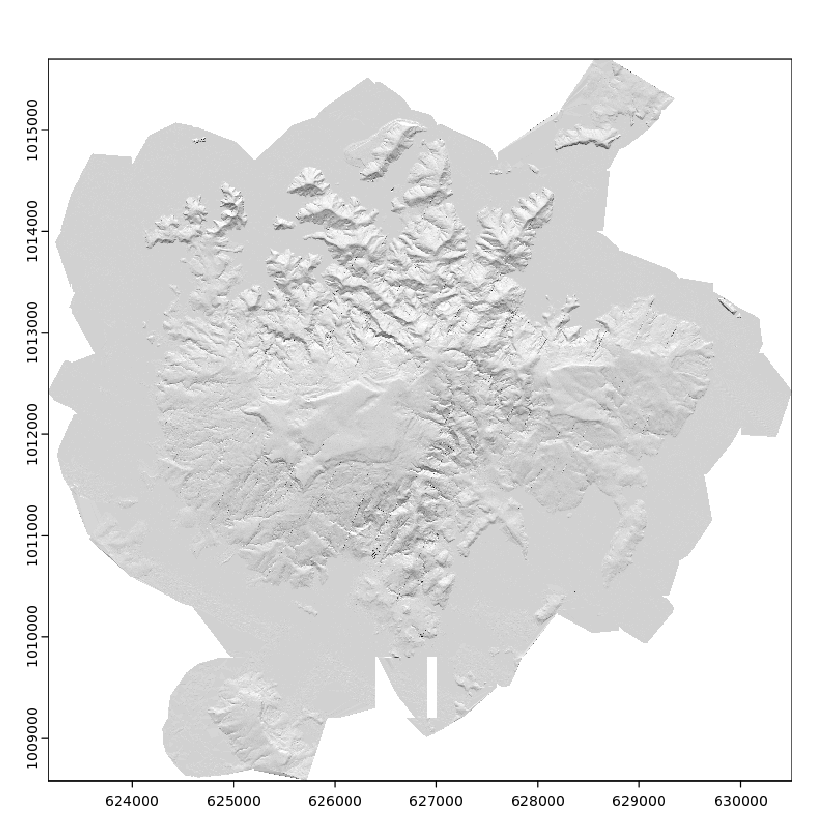

In [22]:
if(overwrite){
    ctg@output_options$drivers$SpatRaster$param$overwrite <- TRUE
    dtm <- suppressWarnings(rasterize_terrain(ctg, 2, tin(), pkg = "terra"))
} else{
    dtm <- terra::vrt(paste0(dtm_path, "/rasterize_terrain.vrt"))
}

dtm_prod <- terra::terrain(dtm, v = c("slope", "aspect"), unit = "radians")
dtm_hillshade <- terra::shade(slope = dtm_prod$slope, aspect = dtm_prod$aspect)
plot(dtm_hillshade, col = gray(0:50/50), legend = FALSE)


***

### **6.** Normalize ALS heights to remove terrain. Extract and plot mean height at 10m resolution before and after normalization.

In [23]:
# Extracting mean height before normalization
opt_chunk_size(ctg) <- 600
opt_chunk_buffer(ctg) <- 40

hmean_path <- paste0(als_path, "/outputs/hmean")
dir.create(hmean_path)

opt_output_files(ctg)<- paste0(hmean_path, "/hmean_chunk_{XCENTER}_{YCENTER}")

if(overwrite){
    hmean <- pixel_metrics(ctg, ~mean(Z), 50, pkg="terra")
} else{
    hmean <- terra::vrt(paste0(hmean_path, "/pixel_metrics.vrt"))
}

Warning message in dir.create(hmean_path):
“'./data/ALS_ground_copc/outputs/hmean' already exists”


In [24]:
# Normalizing canopy height
opt_chunk_size(ctg) <- 400
opt_chunk_buffer(ctg) <- 40
future::plan(multicore, workers = 2)
opt_progress(ctg) <- FALSE
#opt_restart(ctg) <- 265

norm_path <- paste0(als_path, "/outputs/norm")
dir.create(norm_path)

opt_output_files(ctg)<- paste0(norm_path, "/norm_chunk_{XCENTER}_{YCENTER}")

if(overwrite){
    ctg_norm <- normalize_height(ctg, tin(), add_lasattribute = TRUE, dtm=dtm)
} else{
    ctg_norm <- readLAScatalog(norm_path)
}    
    
opt_progress(ctg_norm) <- FALSE

#opt_select(ctg_norm) <- "xyz"
#opt_filter(ctg_norm) <- "-keep_first"

Warning message in dir.create(norm_path):
“'./data/ALS_ground_copc/outputs/norm' already exists”


In [25]:
# Extracting mean height after normalization

ctg_norm@output_options$drivers$SpatRaster$param$overwrite <- TRUE

opt_chunk_size(ctg_norm) <- 600
opt_chunk_buffer(ctg_norm) <- 40
future::plan(multicore, workers = 8)
#opt_restart(ctg_norm) <- 265

hmean_norm_path <- paste0(als_path, "/outputs/hmean_norm")
dir.create(hmean_norm_path)

opt_output_files(ctg_norm)<- paste0(hmean_norm_path, "/hmean_norm_chunk_{XCENTER}_{YCENTER}")

if(overwrite){
    hmean_norm <- pixel_metrics(ctg_norm, ~mean(Z), 50)
} else{
    hmean_norm <- terra::vrt(paste0(hmean_norm_path, "/pixel_metrics.vrt"))
} 


Warning message in dir.create(hmean_norm_path):
“'./data/ALS_ground_copc/outputs/hmean_norm' already exists”


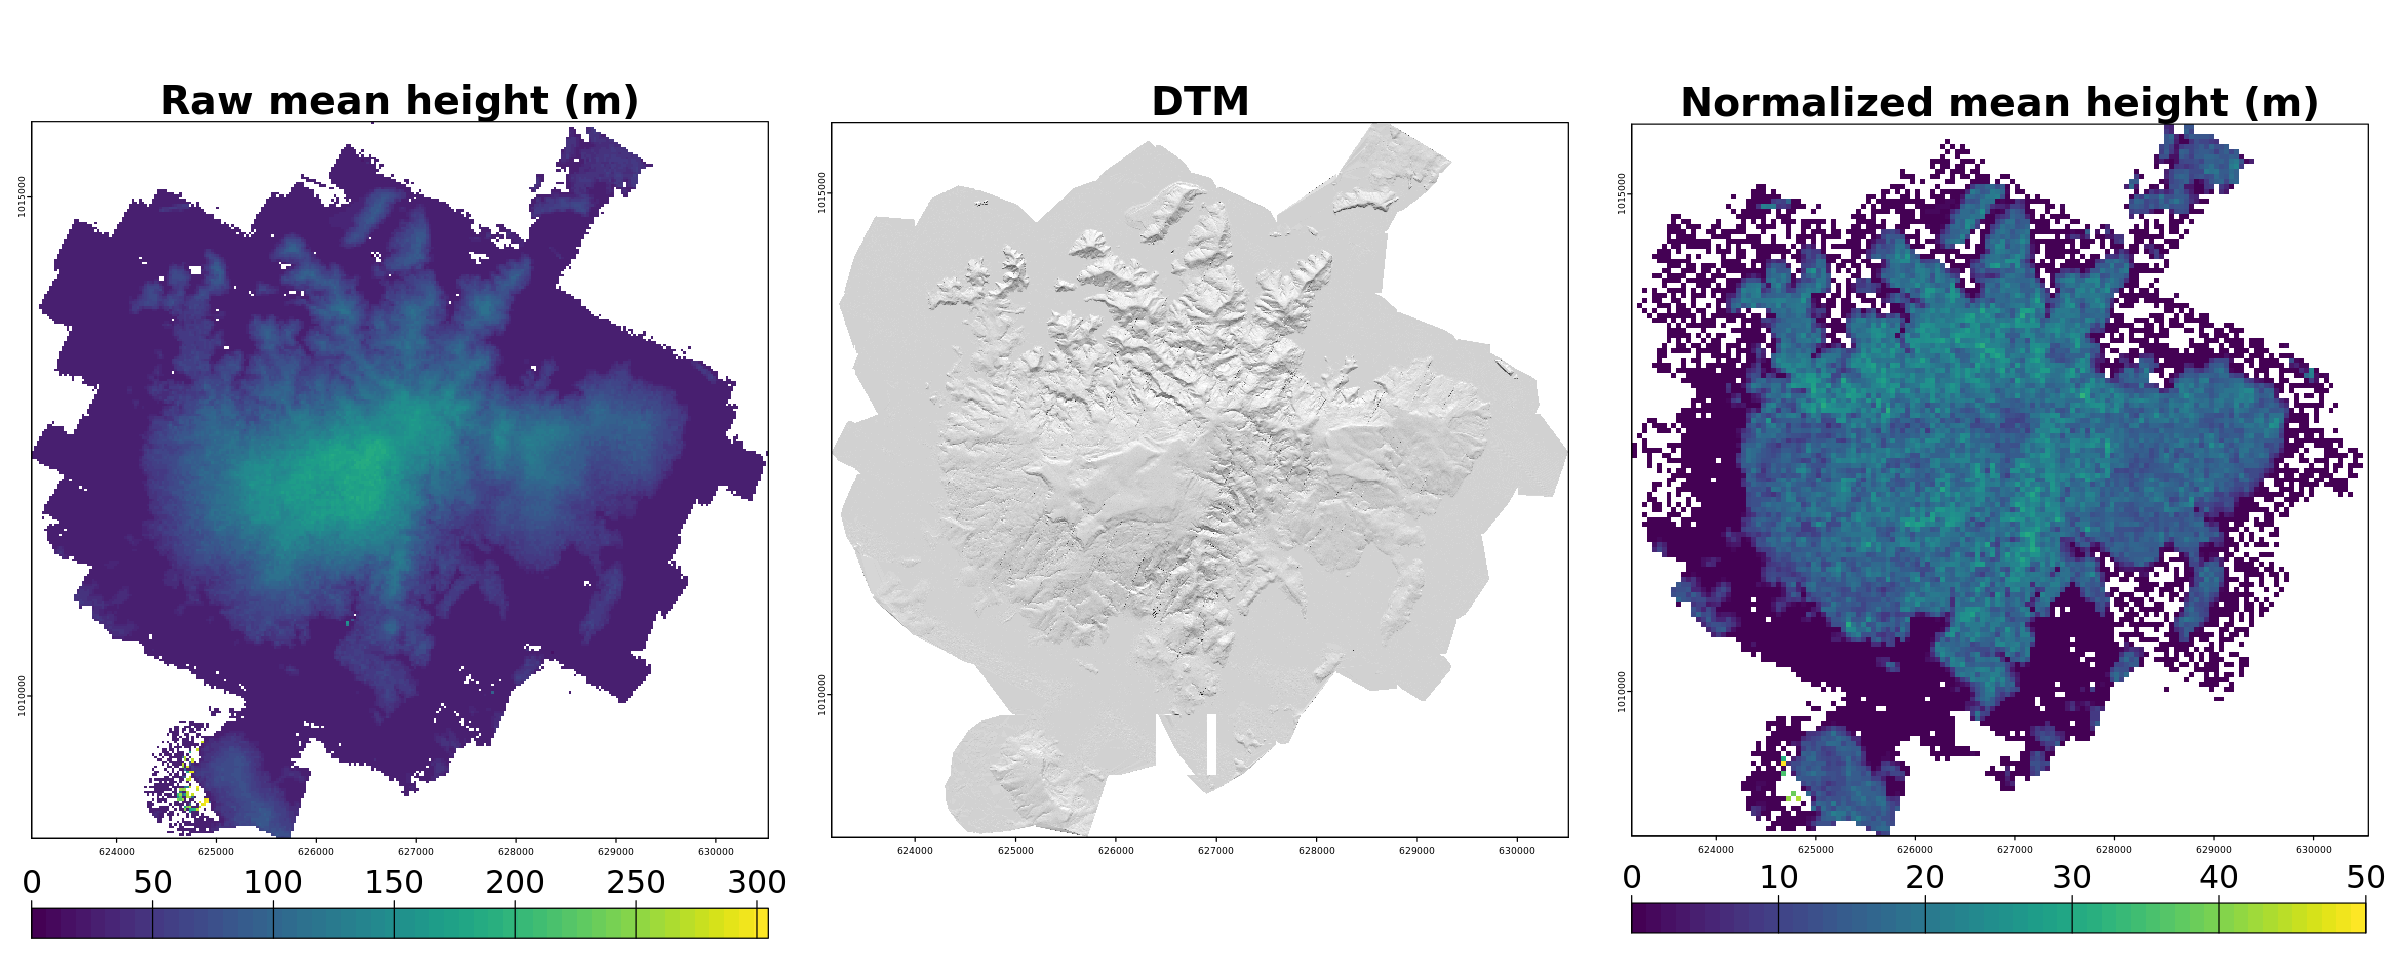

In [26]:
# Plotting mean height before and after normalization

e <- ext(hmean)
leg.e <- c(e[1:2], e[3]-1000, e[3]-700)

par(mfrow=c(1,3))
options(repr.plot.width=20, repr.plot.height=8)
zlim <- as.vector(minmax(hmean))

plot(hmean, col = viridis(50), main="Raw mean height (m)",
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=3), range = c(0,zlim[2]))
plot(dtm_hillshade, col = gray(0:50/50), legend = FALSE, main="DTM", cex.main=3)

zlim <- as.vector(minmax(hmean_norm))
plot(hmean_norm, col = viridis(50), main="Normalized mean height (m)",
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=3), range = c(0,50))



***

### **7.** Create and display a 1-m resolution Canopy Height Model

In [27]:
#Create the canopy height model
ctg_norm@output_options$drivers$SpatRaster$param$overwrite <- TRUE

opt_chunk_size(ctg_norm) <- 400
opt_chunk_buffer(ctg_norm) <- 40
future::plan(multicore, workers = 8)

chm_path <- paste0(als_path, "/outputs/chm")
dir.create(chm_path)

opt_output_files(ctg_norm)<- paste0(chm_path, "/chm_chunk_{XCENTER}_{YCENTER}")

opt_stop_early(ctg_norm) <- FALSE


if(overwrite){
    chm <- rasterize_canopy(ctg_norm, res = 1, pitfree(thresholds = c(0, 10, 20), max_edge = c(0, 1.5)))
} else{
    chm <- terra::vrt(paste0(chm_path, "/rasterize_canopy.vrt"))
} 

Warning message in dir.create(chm_path):
“'./data/ALS_ground_copc/outputs/chm' already exists”


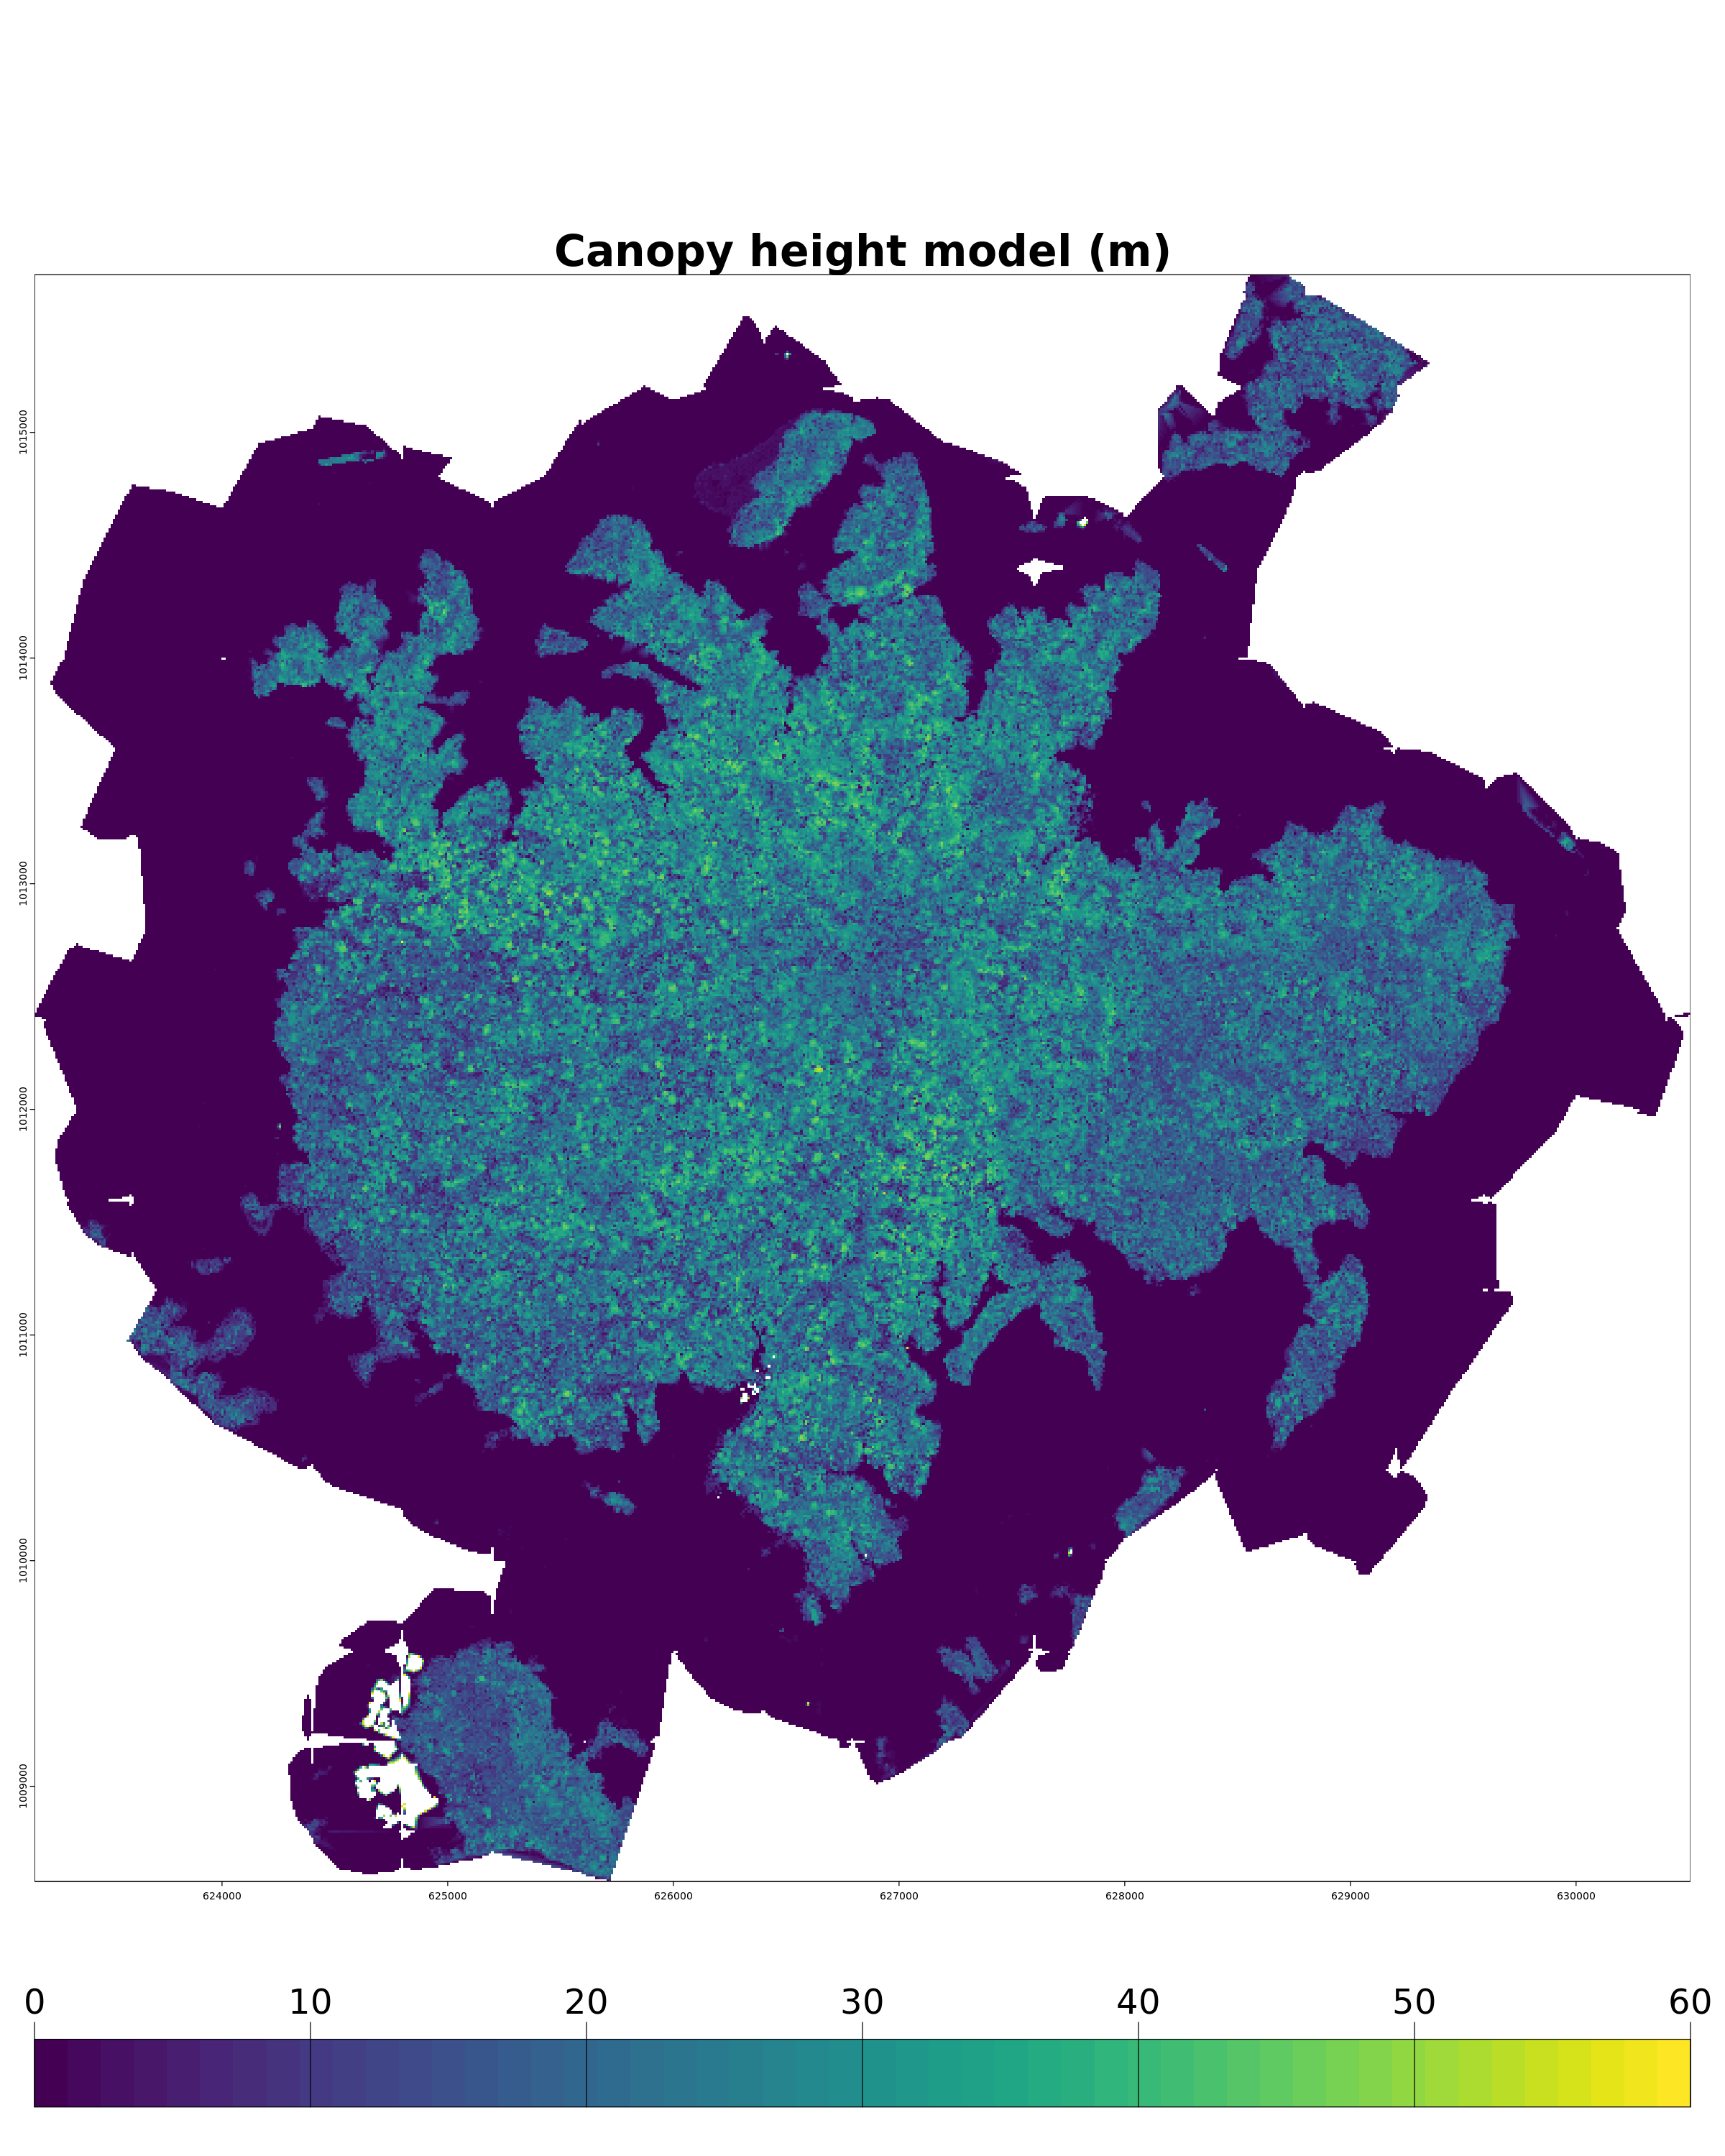

In [28]:
# CHM on a fixed map
options(repr.plot.width=20, repr.plot.height=25)

e <- ext(chm)
leg.e <- c(e[1:2], e[3]-1000, e[3]-700)

plot(chm, col=viridis(50), main="Canopy height model (m)",
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=3),range=c(0,60))

In [19]:
#Plot the CHM on an interactive map

#zlim <- as.vector(minmax(chm$Z))
zlim <- c(0,60)

pal <- colorNumeric(viridis(50),domain=zlim, na.color="#00000000")


m <- leaflet() %>%
  addTiles() %>%  # Add default OpenStreetMap map tiles
  addRasterImage(x=chm, colors = pal, maxBytes = 50000000) %>%
  addLegend(pal = pal, values=zlim)
 
m 


***
### The next steps extract the canopy metrics from the airborne lidar and field plot data necessary for modeling aboveground biomass.
The model shown here follows a Bayesian approach, following Armston et al. 2020. & Fatoyinbo et al. 2021, but this is just one of several approaches available (more will be added in future versions of this notebook).

### **8.** Create function to extract metrics necessary for biomass model as specified in Armston et al. 2020. & Fatoyinbo et al. 2021. Extract metrics from ALS at 50 m resolution

Aboveground biomass density (AGBD; Mg ha$^{-1}$) is modeled as a function of canopy top height (H; m), stand basal area (SBA; m$^{2}$), and wood specific gravity (WSG; g cm$^{-3}$), such that:

&emsp;&emsp; AGBD $= $H$^{\beta_{1}} \ *\ $SBA$^{\beta_{2}} \ *\  $WSG$^{\beta_{3}} \ \ \ $ (1)

Canopy top height is represented by the 98th percentile height metric (P$_{98}$). SBA and WSG are not directly observable from ALS data, so SBA is treated as a function of RH$_{90}$ and total canopy cover (CC$_{z = H_{max}}$):


&emsp;&emsp; SBA = $\gamma_{1}$P$_{90} \ *\ $CC$_{z = H_{max}}$ $\ \ \ \ \ \ \ \ \ \ $ (2)

WSG is drawn from regional WSG estimates in Chave et al. (2009). 



In [8]:
# Create a function to extract canopy cover, P90, and P98 from lidar.
biomassMetrics <- function(z,rn){
  first  <- rn == 1L
  zfirst <- z[first]
  nfirst <- length(zfirst)
  firstabove2 <- sum(zfirst > 2)
  x <- (firstabove2/nfirst)*100
  metrics <- list(
    above2aboven1st = x, # Num of returns above 2m divided by num of 1st returns (canopy cover)
    zp90 = quantile(z, .90),  # 90th quantile of height (i.e. RH90)
    zp98 = quantile(z, .98)  # 98th quantile of height (i.e. RH98)

  )
  
  return(metrics)
    
}

In [9]:
# Extract the canopy metrics from lidar

res <- 50

ctg_norm@output_options$drivers$SpatRaster$param$overwrite <- TRUE
#opt_output_files(ctg) <- paste0(tempdir(), "/{XCENTER}_{YCENTER}_{ID}")

opt_chunk_size(ctg_norm) <- 400
opt_chunk_buffer(ctg_norm) <- 40
future::plan(multicore, workers = 8)
opt_restart(ctg_norm) <- 1


metrics_path <- paste0(als_path, "/outputs/metrics")
dir.create(metrics_path)

opt_output_files(ctg_norm) <- paste0(metrics_path, "/metrics_chunk_{XCENTER}_{YCENTER}")

if(overwrite){
    als_metrics <- pixel_metrics(ctg_norm, ~biomassMetrics(z=Z, rn=ReturnNumber), res, pkg='terra')
} else{
    als_metrics <- terra::vrt(paste0(metrics_path, "/pixel_metrics.vrt"))
    names(als_metrics) <- c("above2aboven1st", "zp90", "zp98")
} 

ERROR: Error in ctg_norm@output_options$drivers$SpatRaster$param$overwrite <- TRUE: object 'ctg_norm' not found


In [22]:
# Set wood specific gravity based on Chave et al. 2014

wsg <- 0.560

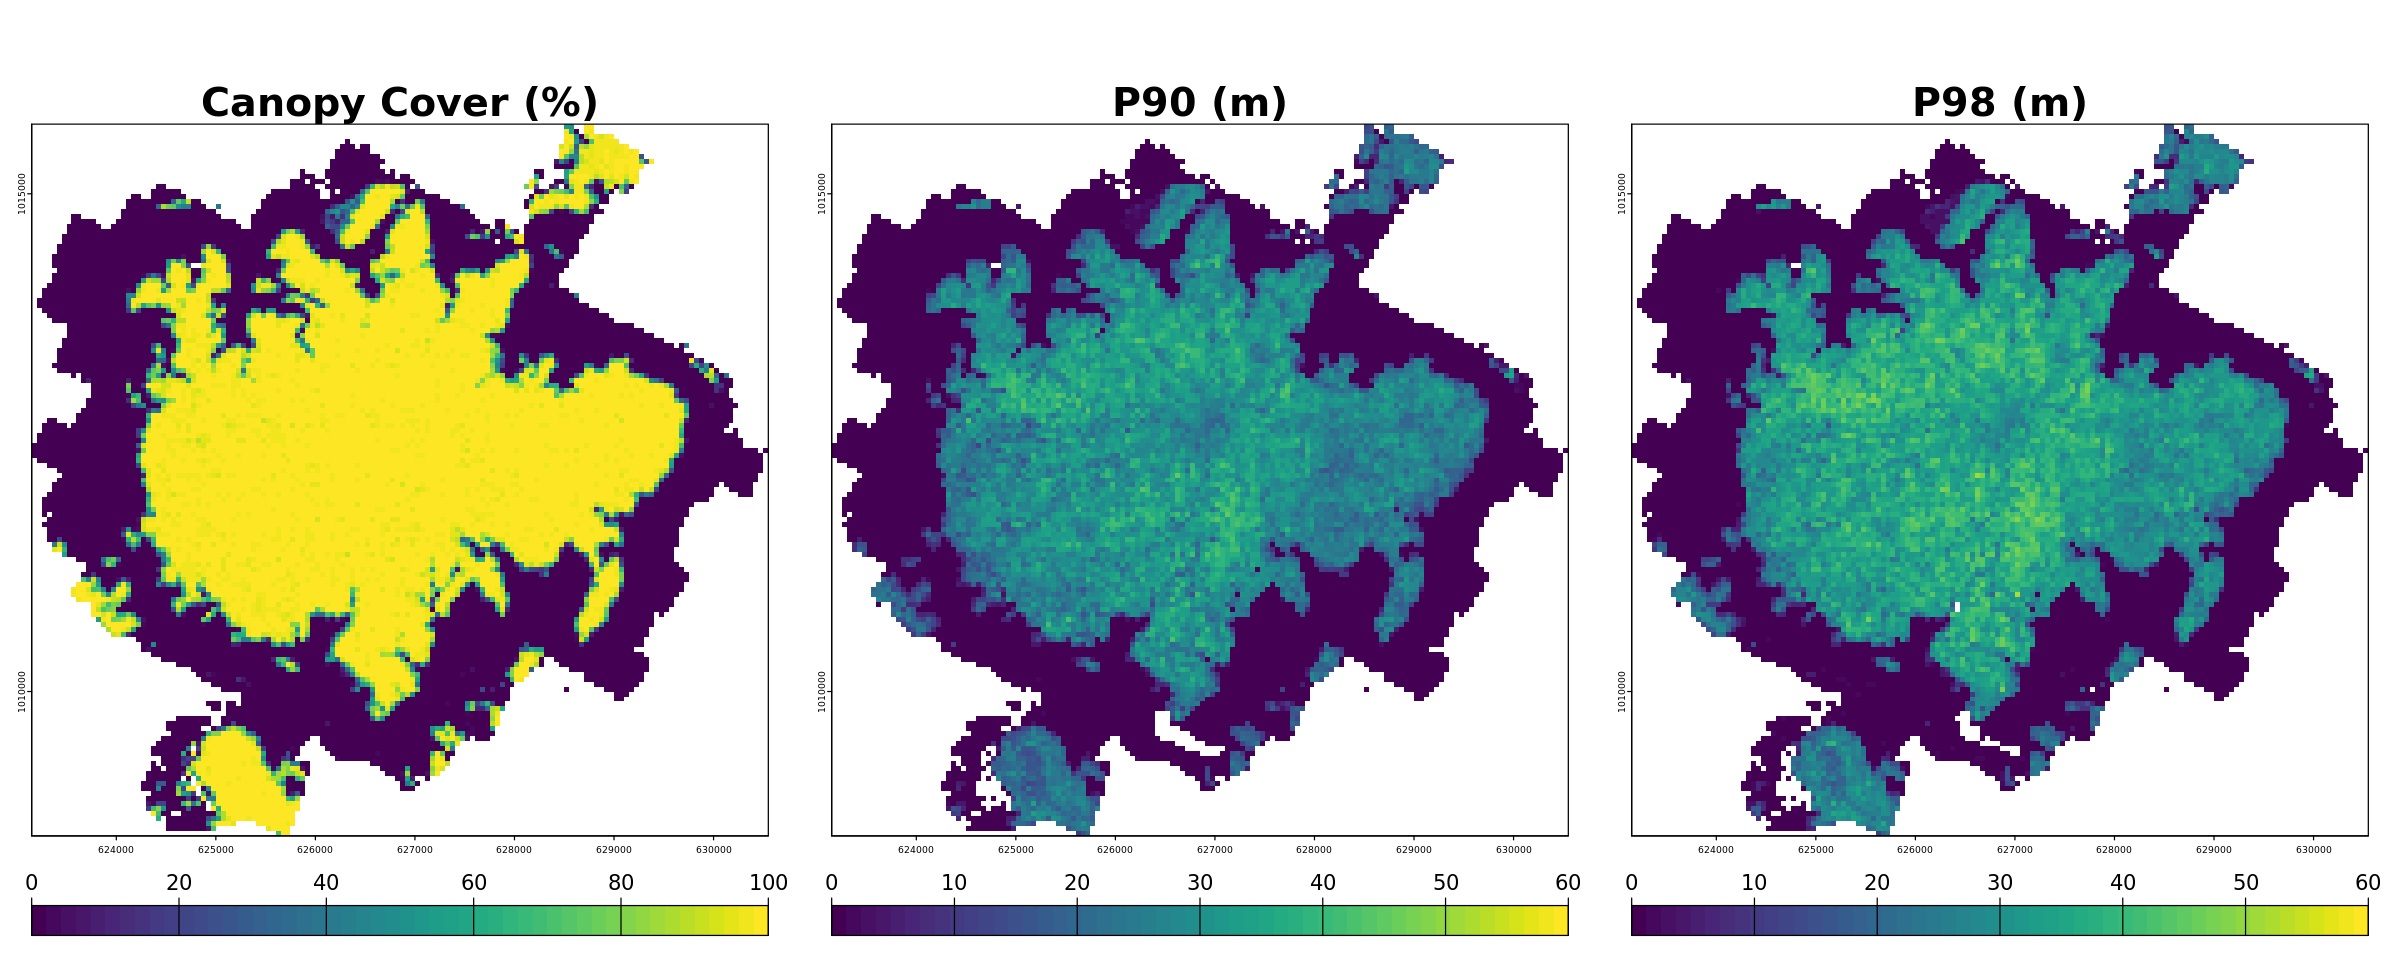

In [23]:
# Plot lidar-derived canopy metrics

options(repr.plot.width=20, repr.plot.height=8)
par(mfrow=c(1,3))

e <- ext(als_metrics)
leg.e <- c(e[1:2], e[3]-1000, e[3]-700)
#zlim <- as.vector(minmax(als_metrics$zp98))
zlim <- c(0,60)

plot(als_metrics$above2aboven1st, col = viridis(50), main="Canopy Cover (%)", 
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=2))


#legend(cex=2)
plot(als_metrics$zp90, col = viridis(50), main="P90 (m)", 
     cex.main=3, plg=list(loc='top', ext=leg.e, cex=2), range=zlim)



plot(als_metrics$zp98, col = viridis(50), main="P98 (m)", 
     cex.main=3, plg=list(loc='top', ext=leg.e, cex=2), range=zlim)


***

### **9.** Read in field data and rasterize AGBD to 50m resolution. Extract ALS metrics over the field plot.
The lidar-derived metrics extracted above will be cropped to the field plot extent. Aboveground biomass density (AGBD) and basal area density (BAD) are derived from the field data.

In [24]:
# Read in field data
fieldData <- readRDS(paste0(field_path, '/gedicalval_panama_bci_20231102_r01.rds'))
plotData <- fieldData$plotdata
treeData <- fieldData$treedata
census2015 <- treeData[treeData$survey==2015 & treeData$status==1,]

In [25]:
# Plot geometry stored as WKT in column p.geom
# Rasterize plot boundaries

p.geom <- st_as_sf(plotData[2,], wkt='p.geom')
plotRaster <- terra::rast(x=p.geom, resolution=res)
plotRaster <- terra::resample(plotRaster, als_metrics)


In [27]:
# Crop plot geometry to remove edge effects
p.geom2 <- st_crop(x=p.geom, y=c(xmin=625800, ymin=1011800, xmax=626750, ymax=1012250))


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [28]:
# Function to rasterize tree biomass values (Kg) and stand basal area (m^2) 
# to aboveground biomass density (Mg/ha) and basal area density (m^2/ha) at desired resolution (m)

rasterize_agbd <- function(x, res){
    total_biomass <- sum(x)
    biomass_density <- total_biomass / (res^2)
    biomass_density <- biomass_density*10 # Kg/m^3 -> Mg/Ha
    return(agbd.ha=biomass_density)
}   

rasterize_sba <- function(x, res){
    total_stand_basal_area <- sum(x)
    basal_area_density <- total_stand_basal_area / (res^2)
    basal_area_density <- basal_area_density*10000 # m^2/m^2 -> m^2/ha
    return(sba.ha=basal_area_density)
}   

In [29]:
fieldBiomass <- terra::rasterize(x=as.matrix(census2015[,c('x','y')]), plotRaster, values=census2015$m.agb, fun=rasterize_agbd, res=res)
fieldSBA <- terra::rasterize(x=as.matrix(census2015[,c('x','y')]), plotRaster, values=census2015$a.stem, fun=rasterize_sba, res=res)

In [30]:
fieldBiomassDF <- terra::extract(fieldBiomass, p.geom2, xy=T)
fieldSBADF <- terra::extract(fieldSBA, p.geom2, xy=T)

colnames(fieldBiomassDF)[colnames(fieldBiomassDF)=='values'] <- 'agbd.ha'
colnames(fieldSBADF)[colnames(fieldSBADF)=='values'] <- 'sba.ha'


***

### **10.** Inspect biomass distribution and predictor variables over field plot

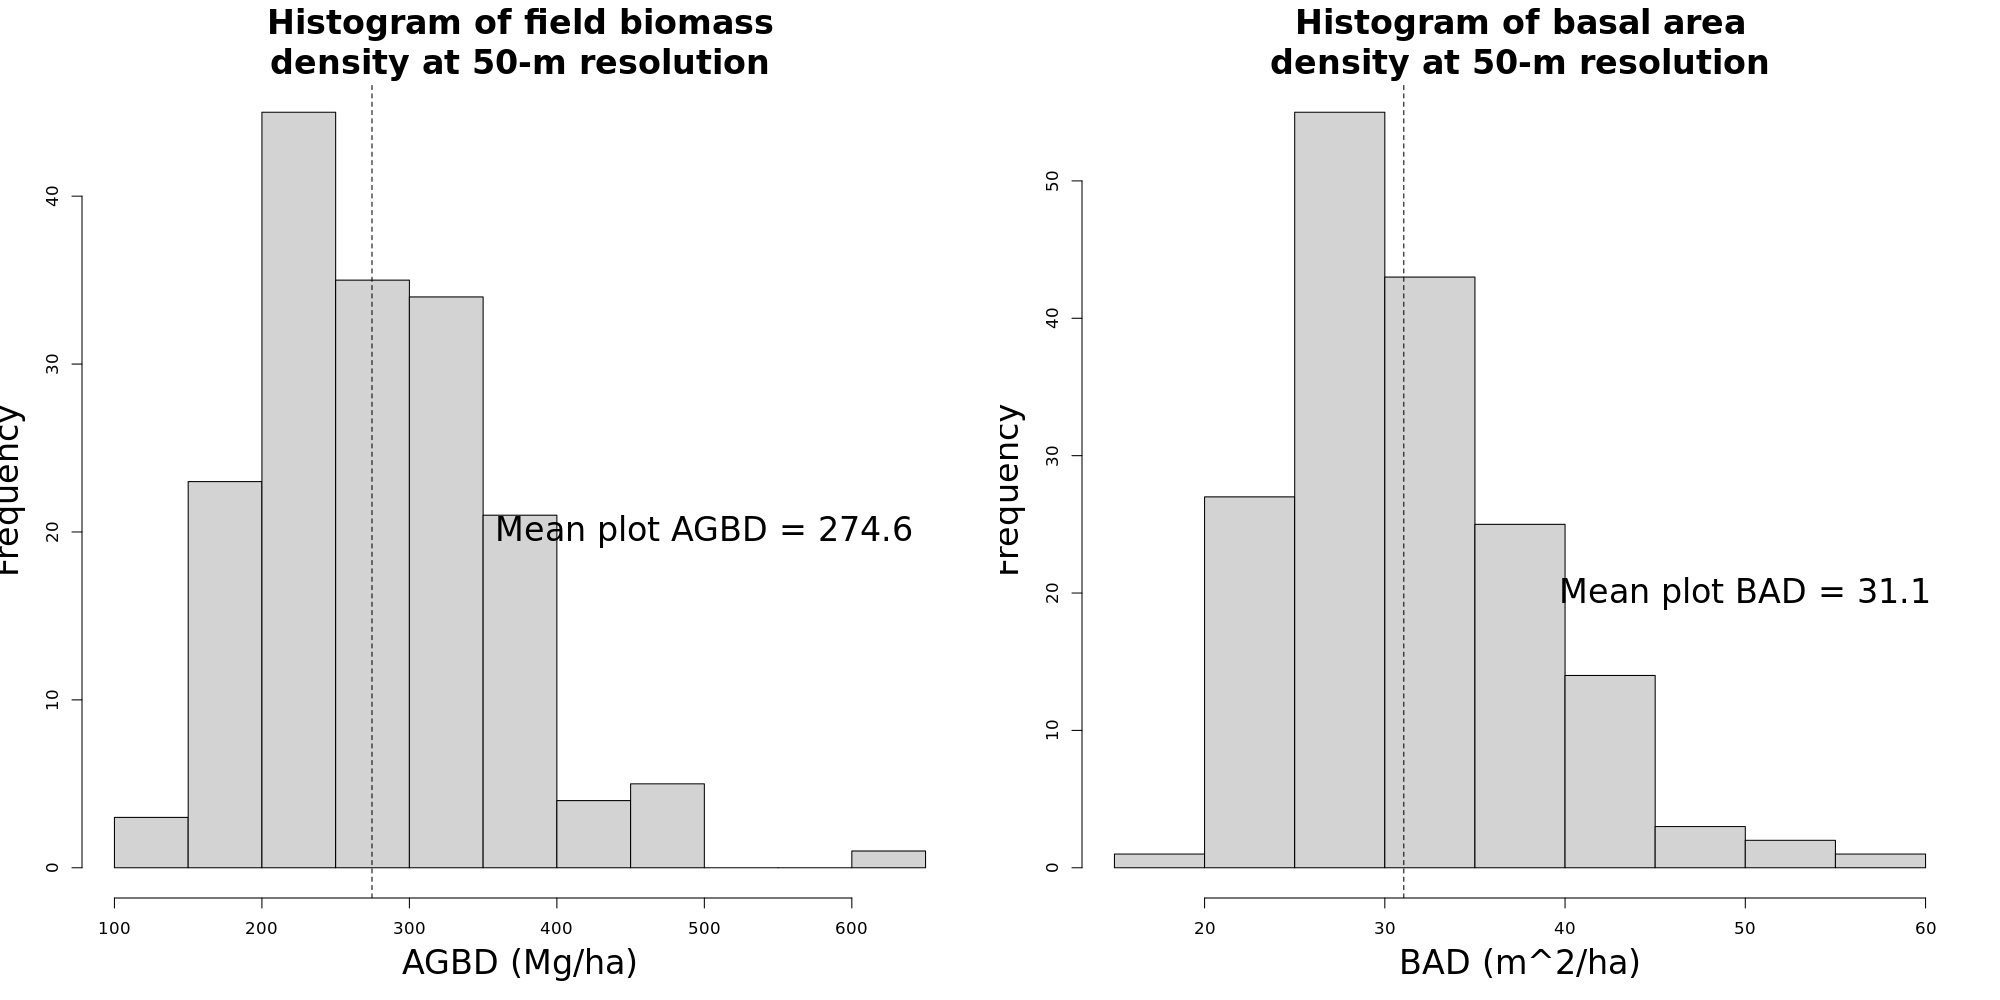

In [31]:
# Plot histograms of field-derived abeground biomass density and basal area density

par(mfrow=c(1,2))
options(repr.plot.width=20, repr.plot.height=10, repr.plot.res=100)

hist(fieldBiomassDF$agbd.ha, main=paste0("Histogram of field biomass\ndensity at ",res,"-m resolution"),
        cex.main=2, xlab = "AGBD (Mg/ha)", cex.lab=2)
abline(v = mean(plotData$agbd.ha), lty=2)
text(x=500, y=20, paste0("Mean plot AGBD = ", round(mean(plotData$agbd.ha, na.rm=T),1)), cex=2)

hist(fieldSBADF$sba.ha, main=paste0("Histogram of basal area\ndensity at ",res,"-m resolution"),
        cex.main=2, xlab = "BAD (m^2/ha)", cex.lab=2)
abline(v = mean(plotData$sba.ha), lty=2)
text(x=50, y=20, paste0("Mean plot BAD = ", round(mean(plotData$sba.ha, na.rm=T),1)), cex=2)

In [32]:
# Crop ALS metrics to plot extent

plotMetrics <- terra::crop(als_metrics, p.geom2)
fieldBiomass <- terra::crop(fieldBiomass, p.geom2)
fieldSBA <- terra::crop(fieldSBA, p.geom2)

In [33]:
# Join field response variables and ALS predictor metrics 
plotMetricsDF <- terra::as.data.frame(plotMetrics, xy=T)
plotMetricsDF <- dplyr::left_join(plotMetricsDF,fieldBiomassDF, by=c('x','y'))
plotMetricsDF <- dplyr::left_join(plotMetricsDF,fieldSBADF, by=c('x','y'))
plotMetricsDF$wsg <- wsg
str(plotMetricsDF)

'data.frame':	171 obs. of  10 variables:
 $ x              : num  625825 625875 625925 625975 626025 ...
 $ y              : num  1012225 1012225 1012225 1012225 1012225 ...
 $ above2aboven1st: num  99.2 99.6 97.9 99.2 97.6 ...
 $ zp90           : num  31.6 27.8 38.9 33.7 26.1 ...
 $ zp98           : num  34.7 31.4 44.4 36.3 31 ...
 $ ID.x           : num  1 1 1 1 1 1 1 1 1 1 ...
 $ agbd.ha        : num  275 197 352 209 170 ...
 $ ID.y           : num  1 1 1 1 1 1 1 1 1 1 ...
 $ sba.ha         : num  32 27.1 38.8 28.2 21.6 ...
 $ wsg            : num  0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56 ...


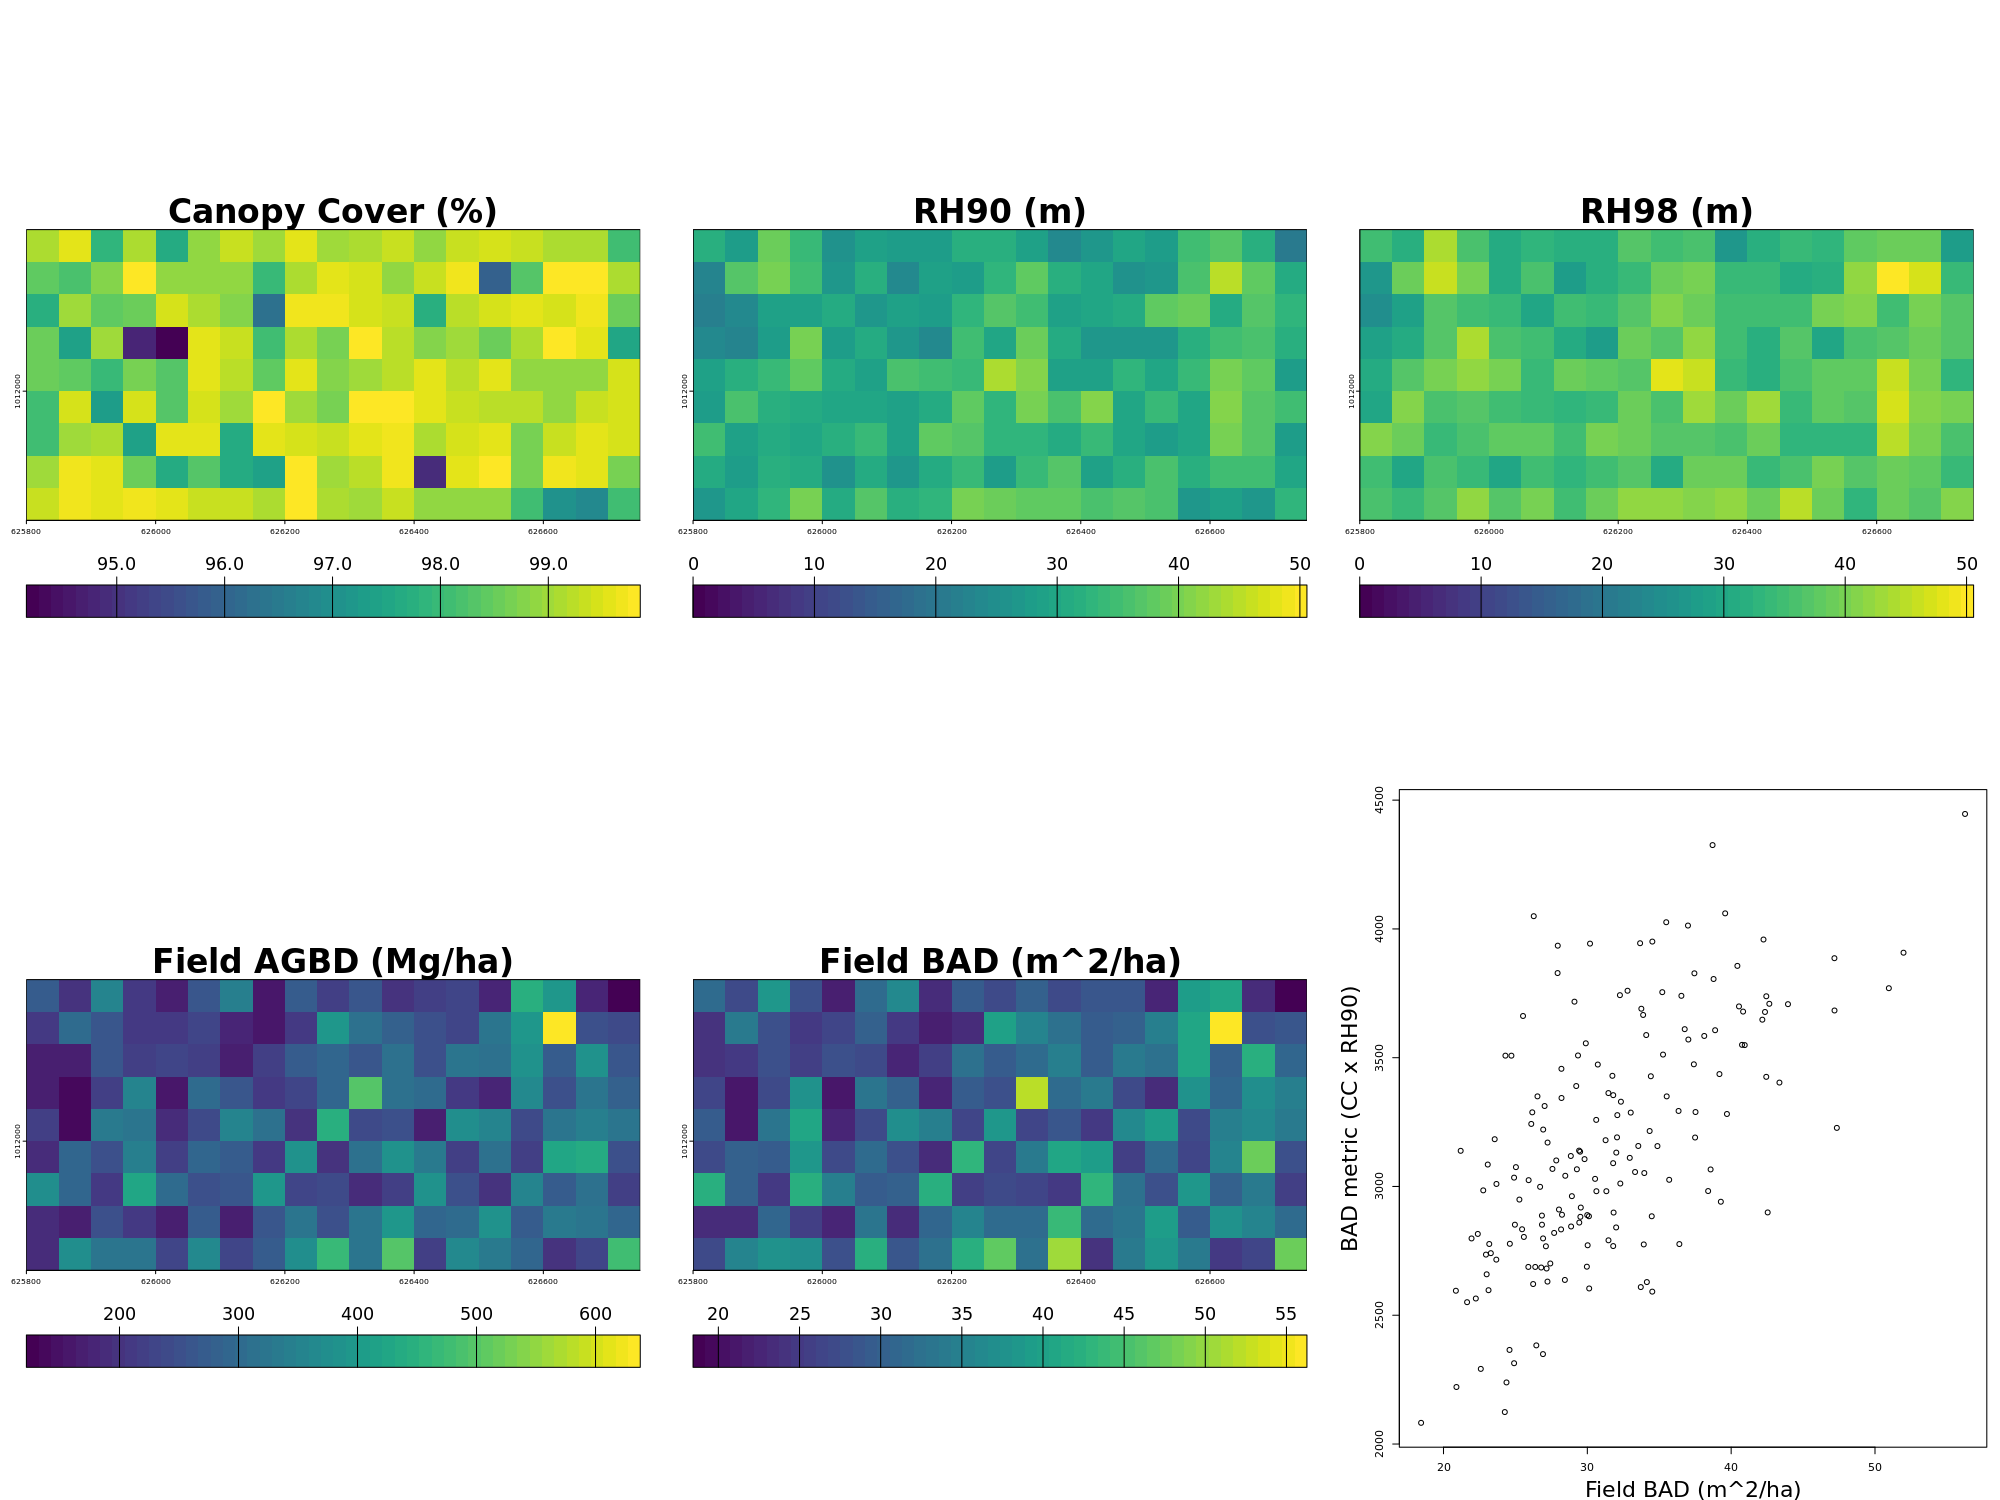

In [34]:
# PLot lidar-derived canopy metrics and field-derived AGBD and BAD over the plot area.

options(repr.plot.width=20, repr.plot.height=15, repr.plot.res=100)
par(mfrow=c(2,3))
e <- ext(plotMetrics)
leg.e <- c(e[1:2], e[3]-150, e[3]-100)
zlim <- as.vector(minmax(plotMetrics$zp98))
zlim[1] <- 0

plot(plotMetrics$above2aboven1st, col = viridis(50), main="Canopy Cover (%)", 
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=2))

plot(plotMetrics$zp90, col = viridis(50), main="RH90 (m)", 
     cex.main=3, plg=list(loc='top', ext=leg.e, cex=2), range=zlim)

plot(plotMetrics$zp98, col = viridis(50), main="RH98 (m)", 
     cex.main=3, plg=list(loc='top', ext=leg.e, cex=2), range=zlim)

plot(fieldBiomass, col=viridis(50), main="Field AGBD (Mg/ha)", 
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=2))

plot(fieldSBA, col=viridis(50), main="Field BAD (m^2/ha)", 
         cex.main=3, plg=list(loc='top', ext=leg.e, cex=2))

par(mar=c(4, 5, 3, 1))
plot(plotMetricsDF$sba.ha,plotMetricsDF$zp90*plotMetricsDF$above2aboven1st,
    xlab="Field BAD (m^2/ha)", ylab="BAD metric (CC x RH90)", cex.lab=2.0)



***
### The following steps fit and predict from the biomass model
A Bayesian model is fit with field-based AGBD being modeled as function of lidar-derived canopy height (P98), basal area density (BAD), and wood specific gravity (WSG). There is also an intermediate model of field-based BAD as a function of lidar-derived P90 and canopy cover. After the model is fit, it can be used to predict AGBD across the whole airborne lidar aquisition.


### **11.** Specify and sample Bayesian model

Using the `greta` package:
1) Convert data to greta arrays

2) Specify variables and priors for the model. A Gamma distribution is used for AGBD to account for heteroscedasticity and positive skewness (Fatoyinbo et al. 2021).

3) Specify operations - see equations 1 and 2 above.

4) Specify likelihood for response variables

5) Specify model, i.e. which variables to track

6) Sample model

In [35]:
# 1) Convert data to greta arrays
sba.ha <- as_data(plotMetricsDF$sba.ha)
p90 <- as_data(plotMetricsDF$zp90)
canopy_cover <- as_data(plotMetricsDF$above2aboven1st)

agbd.ha <- as_data(plotMetricsDF$agbd.ha)
p98 <- as_data(plotMetricsDF$zp98)
wsg <- as_data(plotMetricsDF$wsg)



ℹ Initialising python and checking dependencies, this may take a moment.

✔ Initialising python and checking dependencies ... done!





In [36]:
# 2) Specify variables and priors for the model
beta1 <- normal(0, 1)
beta2 <- normal(0, 1)
beta3 <- normal(0, 1)
gamma1 <- normal(0, 1000)
gamma2 <- normal(0, 1000)
sba.ha.sd <- gamma(0.1,0.1)
#agbd.ha.sd <- gamma(0.1,0.1)
alpha <- gamma(0.1,0.1)

In [37]:
# 3) Specify operations
sba.ha.mean <- gamma1*p90*canopy_cover

agbd.ha.mean <- p98^beta1 * (sba.ha.mean)^beta2 * wsg^beta3

#agbd.ha.shape <- 1 / dispersion
agbd.ha.rate <- alpha/agbd.ha.mean

In [38]:
# 4) Specify likelihood for response variables
distribution(agbd.ha) <- gamma(alpha, agbd.ha.rate)
#distribution(agbd.ha) <- normal(agbd.ha.mean, agbd.ha.sd)

distribution(sba.ha) <- normal(sba.ha.mean, sba.ha.sd)


In [39]:
# 5) Specify model

m <- model(beta1,beta2,beta3,gamma1,alpha,sba.ha.sd)


#### Visualize the model


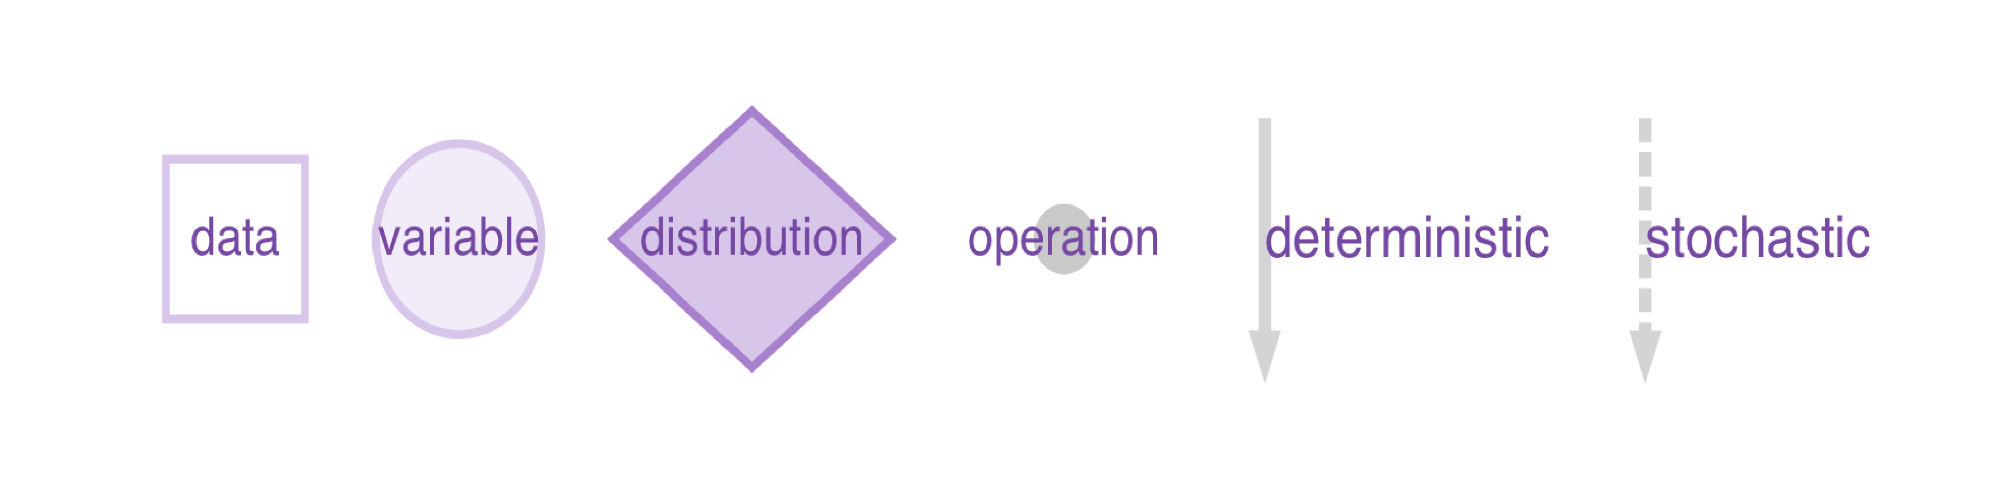

In [40]:
options(repr.plot.width=20, repr.plot.height=5, repr.plot.res=100)

library(png)
pp <- readPNG("/projects/shared-buckets/minord/biomass_reference_maps/greta_plotlegend.png")
plot.new() 
rasterImage(pp,0,0,1,1)

In [41]:
install.packages('DiagrammeR')
library('DiagrammeR')

also installing the dependency ‘igraph’


Warning message in install.packages("DiagrammeR"):
“installation of package ‘igraph’ had non-zero exit status”
Warning message in install.packages("DiagrammeR"):
“installation of package ‘DiagrammeR’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: Error in library("DiagrammeR"): there is no package called ‘DiagrammeR’


In [42]:
# Model visualization

plot(m)

ERROR: Error: [1m[22mthe [34mDiagrammeR[39m package must be installed to plot greta models
install [34mDiagrammeR[39m with:
`install.packages('DiagrammeR')`


In [43]:
# 6) Sample model
future::plan(sequential)
draws <- mcmc(m, thin=10, warmup = 15000, n_samples = 15000, pb_update=1000)

running 4 chains simultaneously on up to 32 cores




    warmup                                          0/15000 | eta:  ?s          

    warmup ==                                    1000/15000 | eta:  4m | 3% bad 

    warmup =====                                 2000/15000 | eta:  4m | 2% bad 

    warmup =======                               3000/15000 | eta:  3m | 1% bad 

    warmup ==========                            4000/15000 | eta:  3m | <1% bad

    warmup ============                          5000/15000 | eta:  3m | <1% bad

    warmup ==============                        6000/15000 | eta:  3m | <1% bad

    warmup =================                     7000/15000 | eta:  2m | <1% bad

    warmup ===================                   8000/15000 | eta:  2m | <1% bad

    warmup ======================                9000/15000 | eta:  2m | <1% bad

    warmup ========================             10000/15000 | eta:  1m | <1% bad

    warmup ==========================           11000/15000 | eta:  1m | <1% bad

    warmup ====

In [44]:
summary(draws)


Iterations = 1:14991
Thinning interval = 10 
Number of chains = 4 
Sample size per chain = 1500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean       SD  Naive SE Time-series SE
beta1      0.418941 0.289589 3.739e-03      3.278e-02
beta2      1.018938 0.255911 3.304e-03      2.569e-02
beta3     -1.038885 0.727228 9.388e-03      1.453e-01
gamma1     0.009937 0.000126 1.626e-06      1.707e-06
alpha     20.830722 2.281064 2.945e-02      1.338e-01
sba.ha.sd  5.276267 0.285887 3.691e-03      3.629e-03

2. Quantiles for each variable:

              2.5%       25%       50%      75%    97.5%
beta1     -0.07527  0.200204  0.398650  0.61621  0.99549
beta2      0.51960  0.839427  1.021393  1.21017  1.47435
beta3     -2.37758 -1.542348 -1.095500 -0.52561  0.45864
gamma1     0.00969  0.009853  0.009936  0.01002  0.01019
alpha     16.57338 19.259121 20.703798 22.30874 25.48802
sba.ha.sd  4.75398  5.074745  5.265889  5.46175  5

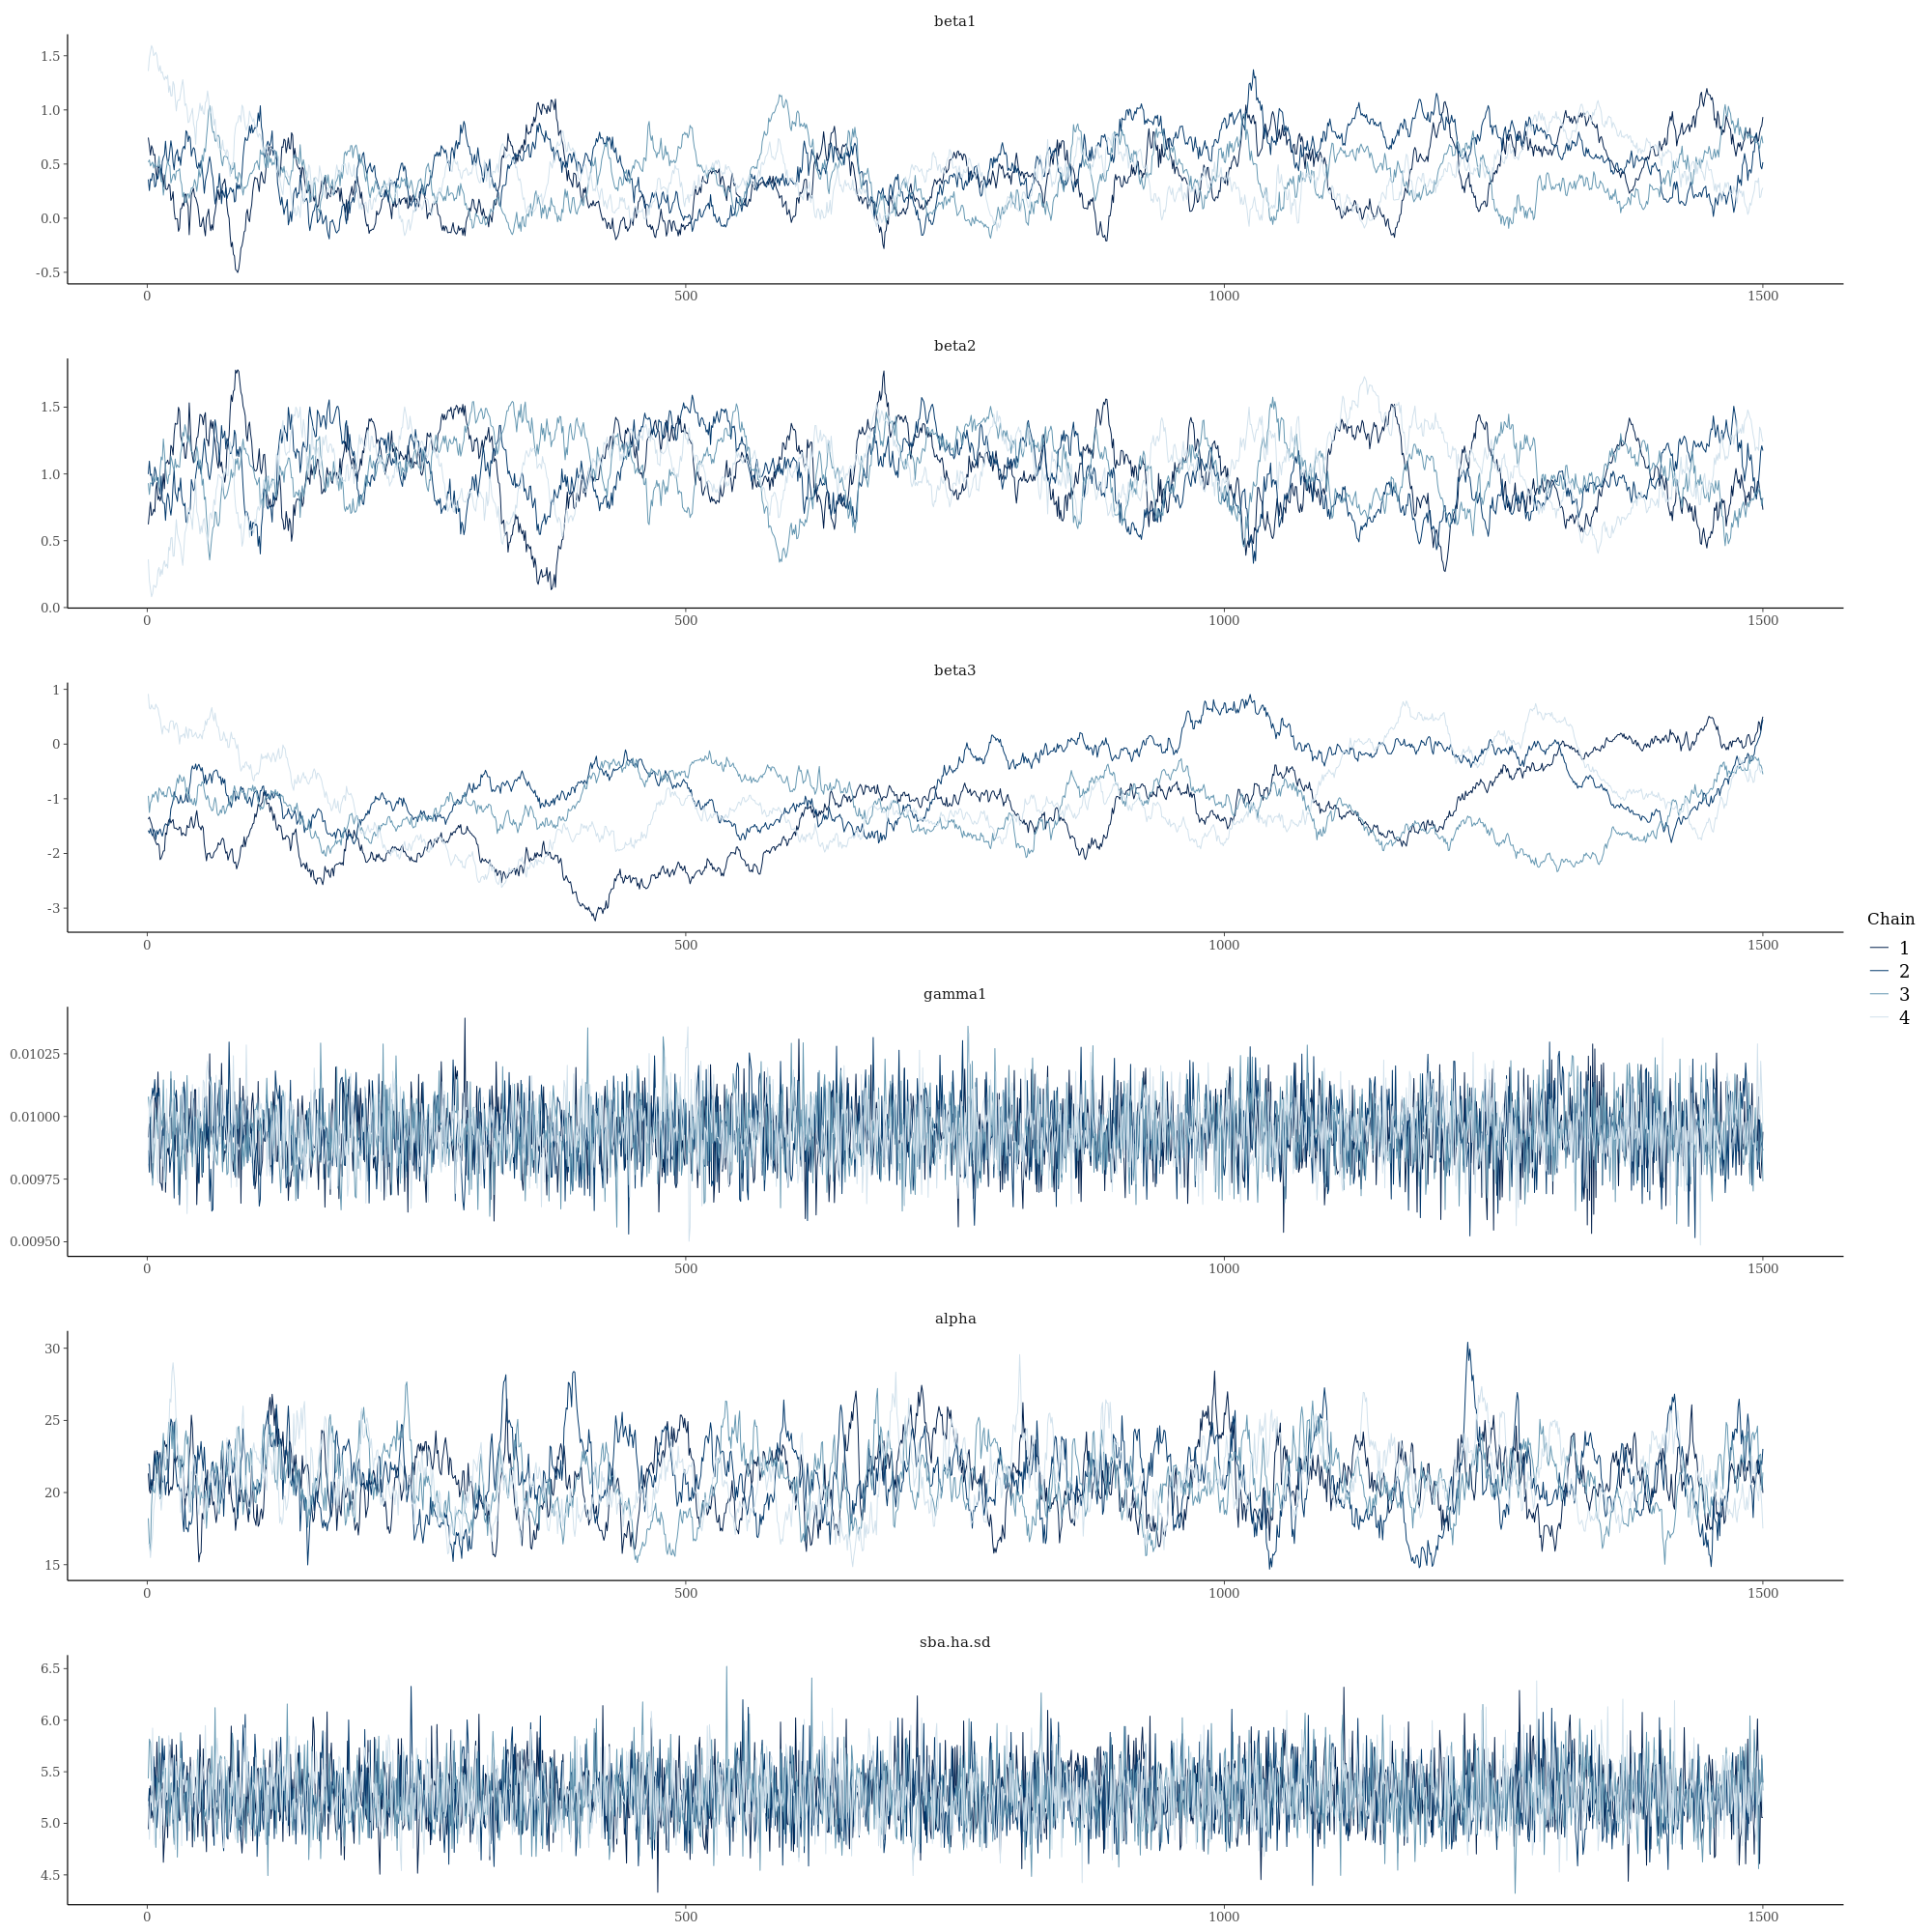

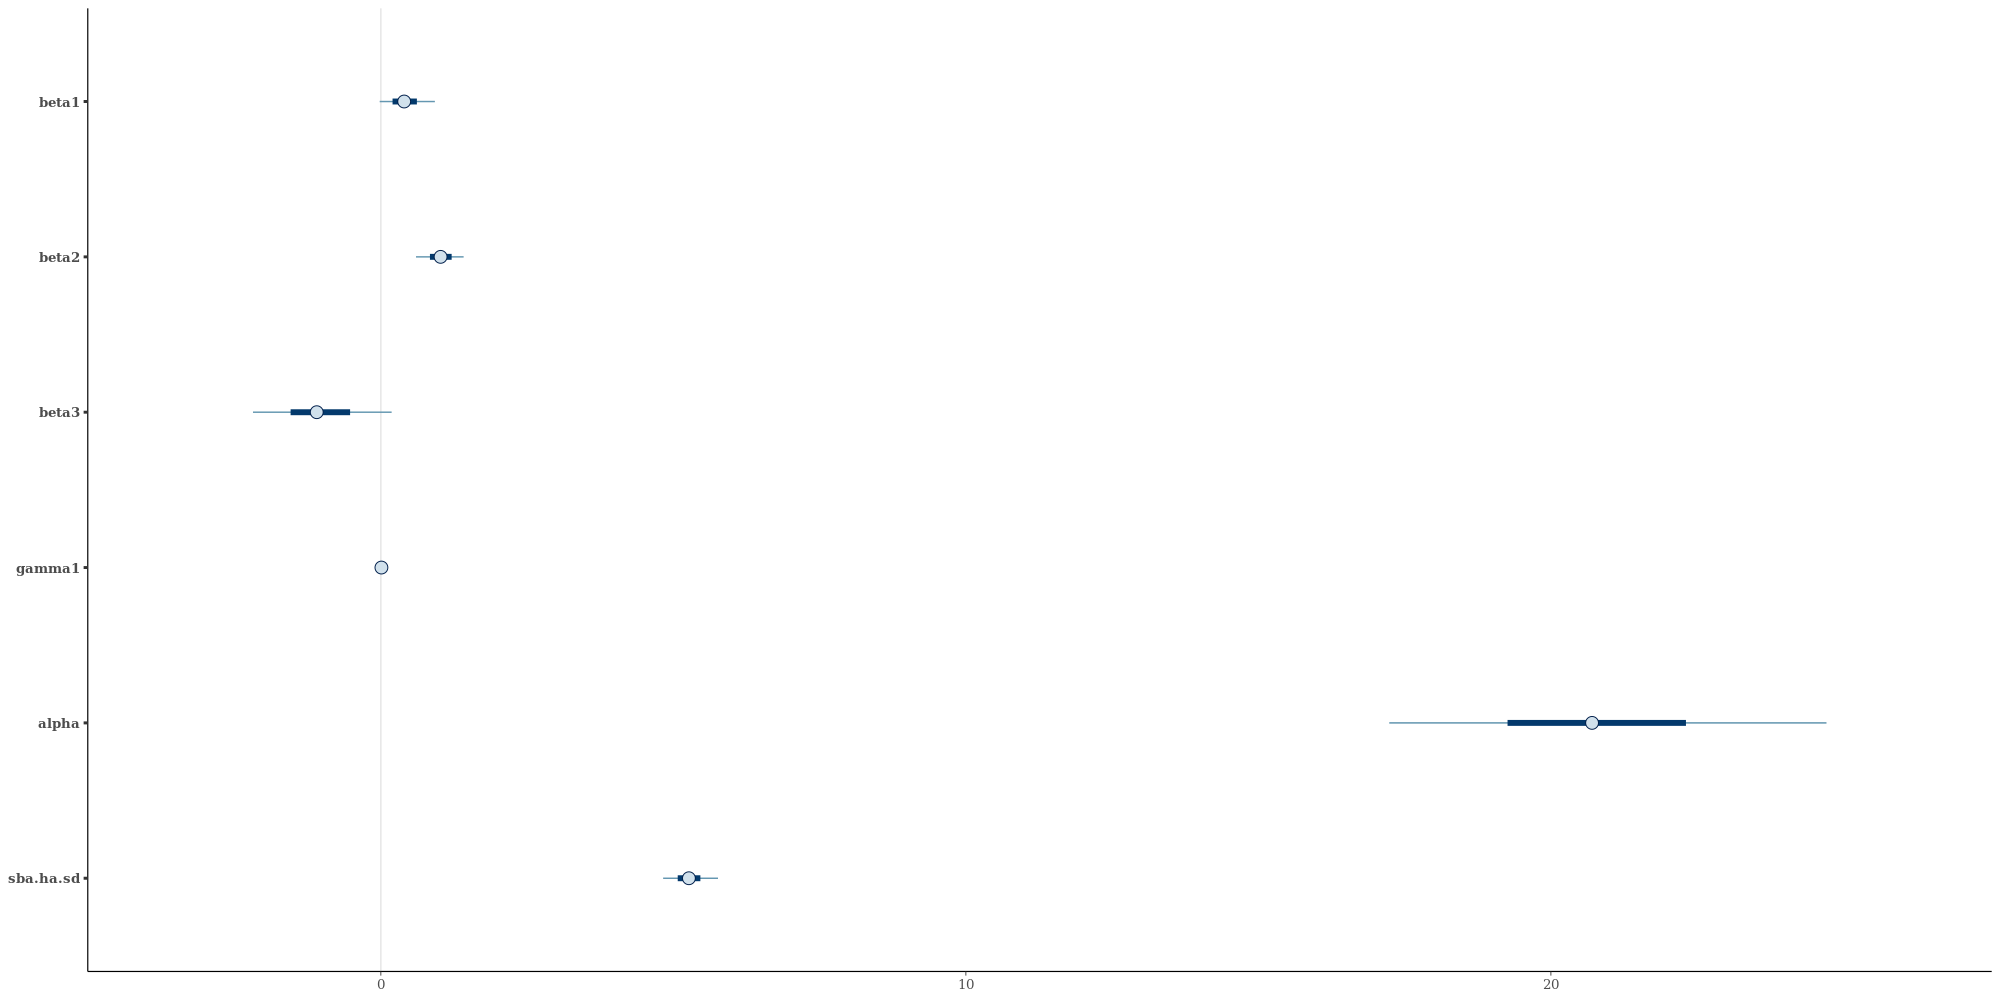

In [45]:
#View sampling chains for each variable

options(repr.plot.width=20, repr.plot.height=20)


mcmc_trace(draws, facet_args = list(nrow = 7, ncol = 1))

options(repr.plot.width=20, repr.plot.height=10)

mcmc_intervals(draws)

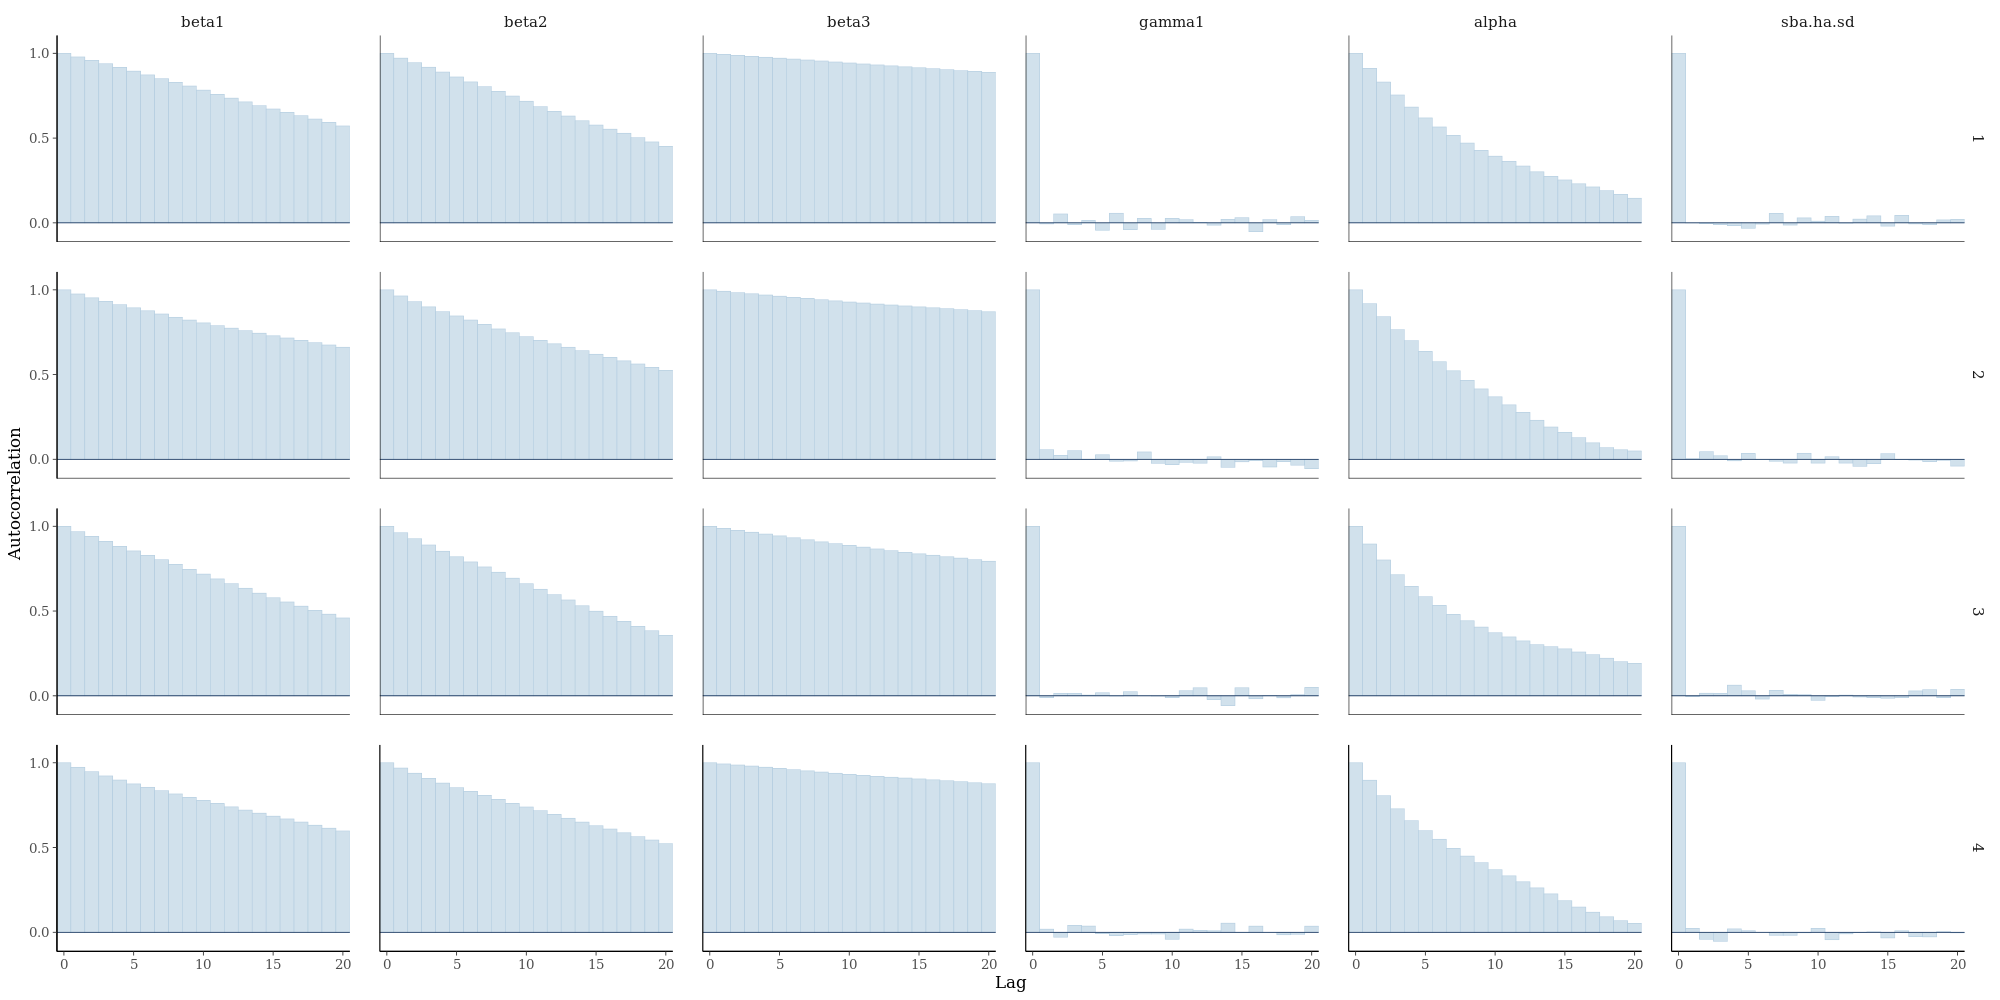

In [46]:
# View autocorrelation within chains

mcmc_acf_bar(draws)



***

### **12.** Predict AGBD over the entire ALS aquisition


In [47]:
# Prepare prediction variables
alsMetricsDF <- terra::as.data.frame(als_metrics, xy=T)
alsMetricsDF$wsg <- 0.560
alsMetricsDF <- alsMetricsDF[!is.na(alsMetricsDF$above2aboven1st),]


str(alsMetricsDF)

'data.frame':	13250 obs. of  6 variables:
 $ x              : num  628525 628575 628725 628775 628525 ...
 $ y              : num  1015675 1015675 1015675 1015675 1015625 ...
 $ above2aboven1st: num  53.8 51.9 99.2 99.1 97.3 ...
 $ zp90           : num  11.8 14.5 16.9 20.4 13.9 ...
 $ zp98           : num  13.5 16.1 18 22.3 15.8 ...
 $ wsg            : num  0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56 0.56 ...


In [48]:
# Predict AGBD from posterior distribution
agbd.predict <- alsMetricsDF$zp98^beta1 * 
                (gamma1 * alsMetricsDF$zp98 * alsMetricsDF$above2aboven1st)^beta2 * 
                alsMetricsDF$wsg^beta3

In [49]:
# Extract mean AGBD and 95% credible intervals from predictions
agbd.est <- calculate(agbd.predict, values=draws)
mu.agbd.est <- colMeans(agbd.est[[1]])

CI.high.agbd.est <- apply(agbd.est[[1]],2, quantile, probs = .975, na.rm=TRUE)
CI.low.agbd.est <- apply(agbd.est[[1]],2, quantile, probs = .025, na.rm=TRUE)
CI.agbd.est <- CI.high.agbd.est - CI.low.agbd.est

sd.agbd.est <- apply(agbd.est[[1]],2, sd, na.rm=TRUE)

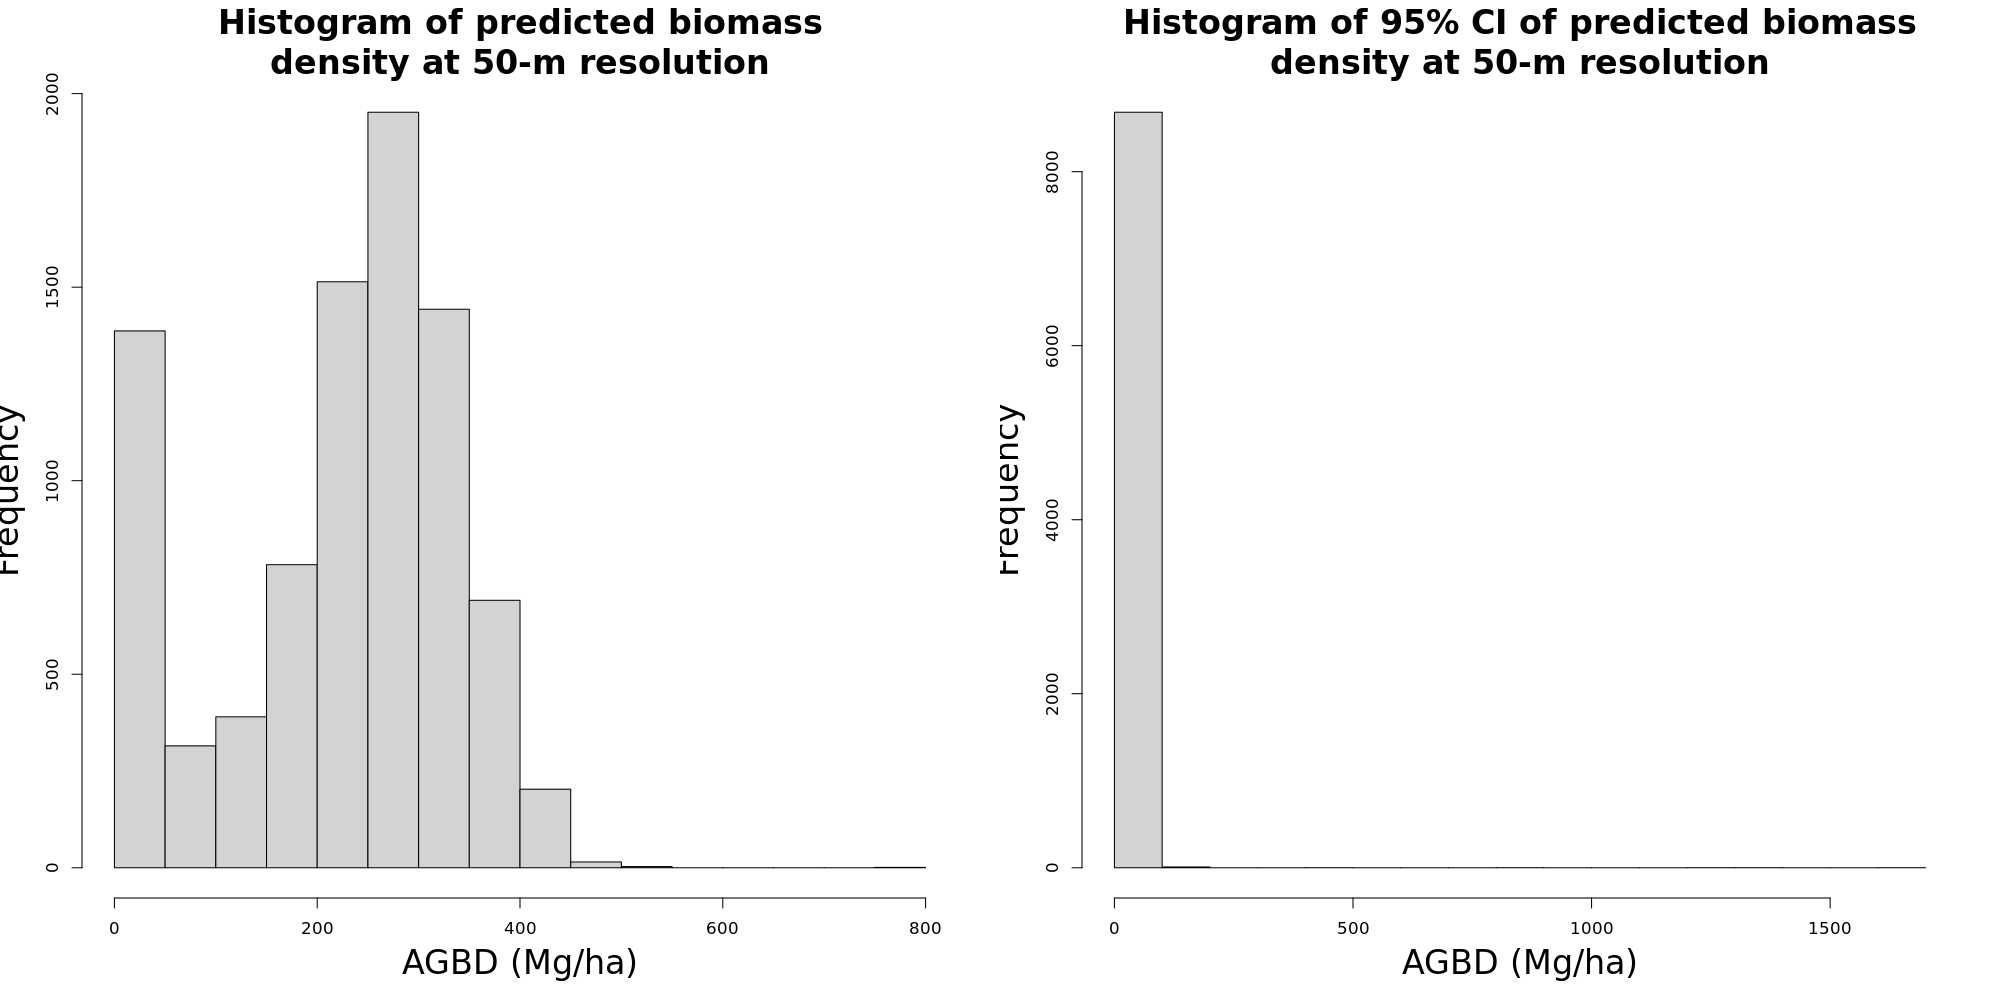

In [50]:
par(mfrow=c(1,2))
options(repr.plot.width=20, repr.plot.height=10, repr.plot.res=100)

hist(mu.agbd.est[mu.agbd.est>0 & mu.agbd.est<800], main=paste0("Histogram of predicted biomass\ndensity at ",res,"-m resolution"),
        cex.main=2, xlab = "AGBD (Mg/ha)", cex.lab=2)
hist(CI.agbd.est[mu.agbd.est>0 & mu.agbd.est<800], main=paste0("Histogram of 95% CI of predicted biomass\ndensity at ",res,"-m resolution"),
        cex.main=2, xlab = "AGBD (Mg/ha)", cex.lab=2)

In [51]:
alsMetricsDF$agbd.est <- mu.agbd.est
alsMetricsDF$agbd.est.CI <- CI.agbd.est

In [52]:
agbd.pred.rast <- terra::rast(alsMetricsDF)
# names(agbd.pred.rast) <- c("agbd","ci") #so the bands have good names
f <- "data/ALS_ground_copc/outputs/agbd.tif"
crs(agbd.pred.rast) <- "epsg:32617"
writeRaster(agbd.pred.rast, f, overwrite=TRUE, filetype="COG")

### Plot AGBD predictions and credible interval. 
Uncertainty is higher in higher AGBD areas by design, as a result of the Gamma error distribution used to reflect natural heteroscedasticity in biomass data.

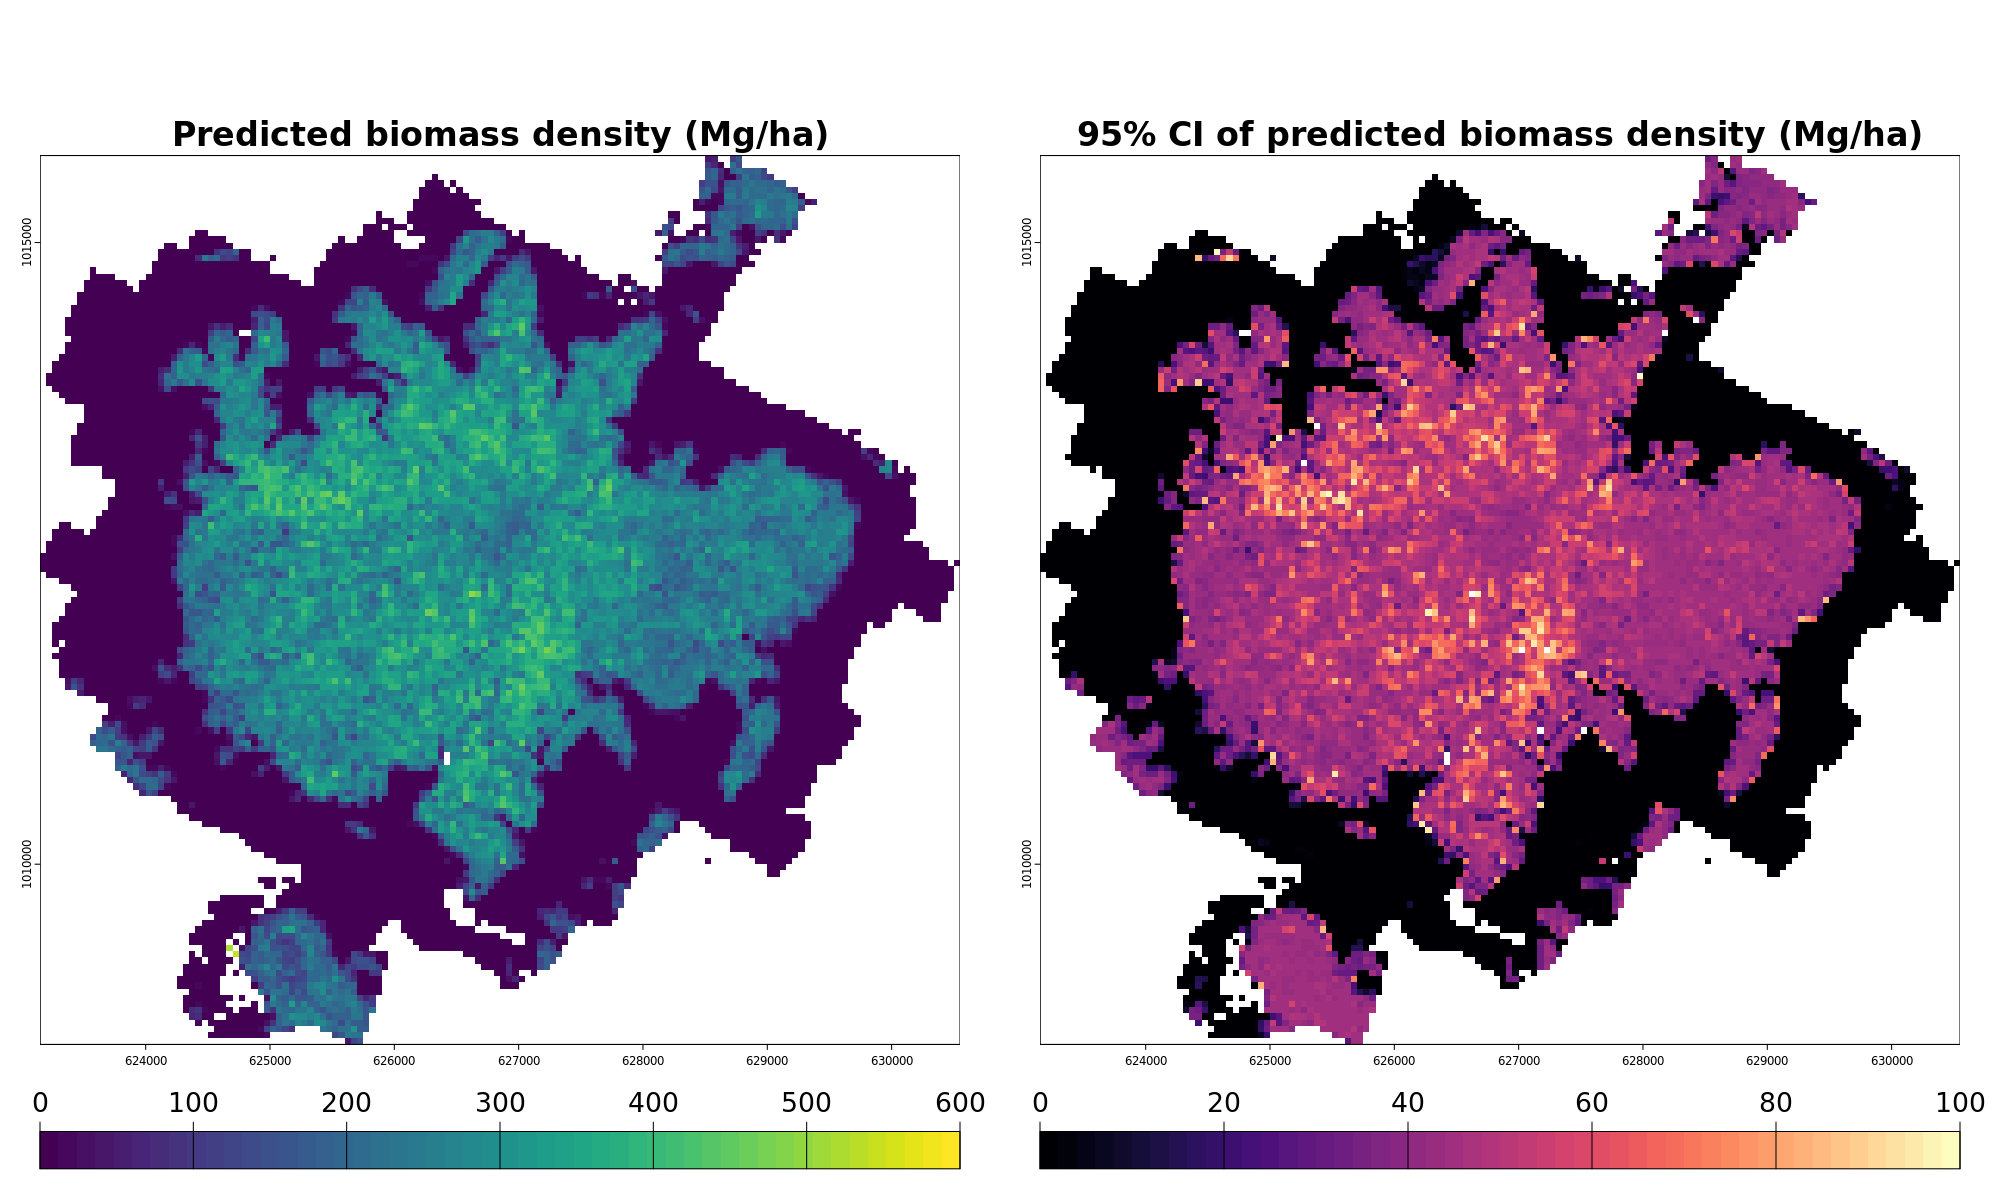

In [53]:
par(mfrow=c(1,2))
options(repr.plot.width=20, repr.plot.height=12)

#zlim <- as.vector(minmax(agbd.pred.rast$agbd.est))
zlim <- c(0,600)

e <- ext(agbd.pred.rast)
leg.e <- c(e[1:2], e[3]-1000, e[3]-700)


plot(agbd.pred.rast$agbd.est, col=viridis(50), main="Predicted biomass density (Mg/ha)", 
         cex.main=2, plg=list(loc='top', ext=leg.e, cex=2), range=zlim)


zlim <- c(0,100)


plot(agbd.pred.rast$agbd.est.CI, col=magma(50), main="95% CI of predicted biomass density (Mg/ha)", 
         cex.main=2, plg=list(loc='top', ext=leg.e, cex=2), range=zlim)




***

### **13.** Validation

Leave-one-out cross-validation to be implemented


***

### **14.** Comparison with the Meta 1-m Canopy Cover Product



In [3]:
library(terra)
meta_chm <-rast("s3://maap-ops-workspace/shared/alexdevseed/geotrees/meta_chm_032221130_cog.tif")

terra 1.7.55



The Meta CHM layer has a Projected CRS of WGS 84 / Pseudo-Mercator, so we need to re-project the extent to the AGBD layer extent for analysis.

In [40]:
crs(meta_chm)

[1] "PROJCRS[\"WGS 84 / Pseudo-Mercator\",\n    BASEGEOGCRS[\"WGS 84\",\n        DATUM[\"World Geodetic System 1984\",\n            ELLIPSOID[\"WGS 84\",6378137,298.257223563,\n                LENGTHUNIT[\"metre\",1]]],\n        PRIMEM[\"Greenwich\",0,\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n        ID[\"EPSG\",4326]],\n    CONVERSION[\"unnamed\",\n        METHOD[\"Popular Visualisation Pseudo Mercator\",\n            ID[\"EPSG\",1024]],\n        PARAMETER[\"Latitude of natural origin\",0,\n            ANGLEUNIT[\"degree\",0.0174532925199433],\n            ID[\"EPSG\",8801]],\n        PARAMETER[\"Longitude of natural origin\",0,\n            ANGLEUNIT[\"degree\",0.0174532925199433],\n            ID[\"EPSG\",8802]],\n        PARAMETER[\"False easting\",0,\n            LENGTHUNIT[\"metre\",1],\n            ID[\"EPSG\",8806]],\n        PARAMETER[\"False northing\",0,\n            LENGTHUNIT[\"metre\",1],\n            ID[\"EPSG\",8807]]],\n    CS[Cartesian,2],\n        AXIS[\"easting (X)\",east,\n            ORDER[1],\n            LENGTHUNIT[\"metre\",1]],\n        AXIS[\"northing (Y)\",north,\n            ORDER[2],\n            LENGTHUNIT[\"metre\",1]],\n    USAGE[\n        SCOPE[\"Web mapping and visualisation.\"],\n        AREA[\"World between 85.06°S and 85.06°N.\"],\n        BBOX[-85.06,-180,85.06,180]],\n    ID[\"EPSG\",3857]]"

Reprojecting the AGBD layer extent to Meta CHM layer CRS. 

In [31]:
e_proj <- project(e, "EPSG:32617", "EPSG:3857")

In [32]:
e_proj

SpatExtent : -8892100.12539225, -8884643.50475591, 1019798.46779485, 1027082.4935628 (xmin, xmax, ymin, ymax)

Cropping the CHM tile corresponding to the AGBD layer extent.

In [34]:
meta_chm_cropped <- crop(meta_chm, e_proj)

Reprojecting the cropped Meta CHM Layer to AGBD layer CRS. 

In [36]:
meta_chm_cropped_proj = project(meta_chm_cropped, "EPSG:32617")

Writing the cropped CHM layer output as COG.

In [37]:
meta_f <- "data/ALS_ground_copc/outputs/meta_chm.tif"
writeRaster(meta_chm_cropped_proj, meta_f, overwrite=TRUE, filetype="COG")

### References

Armston, J., H. Tang, S. Hancock, S. Marselis, L. Duncanson, J. Kellner, M. Hofton, J.B. Blair, T. Fatoyinbo, and R.O. Dubayah. 2020. AfriSAR: Gridded Forest Biomass and Canopy Metrics Derived from LVIS, Gabon, 2016. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1775

Chave, J., D. Coomes, S. Jansen, S.L. Lewis, N.G. Swenson, and A.E. Zanne. 2009. Towards a worldwide wood economics spectrum. Ecology Letters, 12:351–366. https://doi.org/10.1111/j.1461-0248.2009.01285.x

Fatoyinbo, T., Armston, J., Simard, M., Saatchi, S., Denbina, M., Lavalle, M., ... & Hibbard, K. 2021. The NASA AfriSAR campaign: Airborne SAR and lidar measurements of tropical forest structure and biomass in support of current and future space missions. Remote Sensing of Environment, 264, 112533. https://doi.org/10.1016/j.rse.2021.112533

In [56]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/r/lib/libopenblasp-r0.3.26.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] png_0.1-8         bayesplot_1.11.1  greta_0.4.5       leaflet_2.2.1    
 [5] viridis_0.6.4     viridisLite_0.4.2 aws.s3_0.3.21     rstac_1.0.0      
 [9] terra_1.7-55      future_1.33.2     sf_1.0-14         lidR_4.0.4       

loaded via a namespace (and not attached):
 [1] progress_1.2.3       httr_1.4.7           repr_1.1.7          
 [4] tensorA_0.36.2.1    